# Assignment Week 1-4:Image (Pre-)Processing, Quality Assurance prior to DL training.ipynb

Created by: **Mikael Del Castillo**, **Malinda Huang**

**Overview**:

This assigment will go over:
* Basic data exploration
* Preprocessing MRI with TorchIO
  - Spatial transformations
  - Data augmentation
  - Intensity transformations




# Import libraries, packages, and dataset
First, lets import all the libraries and dataset needed for this assigment.

We will visualize the MRI images of another patient from the same Kaggle dataset that we used in the workshop (https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation).

In [ ]:
!pip install torchio==0.18.70 --quiet
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt

# Loading and processing
import os
import numpy as np
import pandas as pd
import nibabel as nib

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Torch IO
import copy
import time
import pprint

import torch
import torchio as tio
import seaborn as sns; sns.set() # statistical data visualization

sns.set_style("whitegrid", {'axes.grid' : False})
%config InlineBackend.figure_format = 'retina'
torch.manual_seed(14041931)
mni = tio.datasets.Colin27()

print('TorchIO version:', tio.__version__)
print('Last run on', time.ctime())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.3/164.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.7 MB/s eta 0:00:00


24256512it [00:00, 38655748.43it/s]                              


TorchIO version: 0.18.70
Last run on Thu Apr 11 04:20:48 2024


In [ ]:
import shutil
project_dir = 'ImagePreprocessing'
%cd /content
if os.path.exists(project_dir):
  shutil.rmtree(project_dir)
else:
  os.mkdir(project_dir)
!git clone https://github.com/MalindaH/ImagePreprocessing.git
%cd ImagePreprocessing
!unzip /content/ImagePreprocessing/BraTS20_Training_002_t2.nii.zip -d /content/BraTS20_Training_002_t2.nii
!rm -rf *.zip

/content
Cloning into 'ImagePreprocessing'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 1.96 MiB | 28.62 MiB/s, done.
/content/ImagePreprocessing
Archive:  /content/ImagePreprocessing/BraTS20_Training_002_t2.nii.zip
  inflating: /content/BraTS20_Training_002_t2.nii/BraTS20_Training_002_t2.nii  


# Excercise 1: Data Exploration

Let's explore our dataset by loading one sample MRI scan!
Use the path defined bellow.

In [ ]:
# Use this path when loading your image, make sure you run this section
file_path = "/content/BraTS20_Training_002_t2.nii/BraTS20_Training_002_t2.nii"

In [ ]:
#@title ## Run me! (Visualization functions from the workshop)

#Function to display row of image slices
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for idx, slice in enumerate(slices):
        axes[idx].imshow(slice.T, cmap="gray", origin="lower")

    axes[0].set_xlabel('Second dim voxel coords.', fontsize=12)
    axes[0].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[0].set_title('First dimension (i), slice {}'.format(i), fontsize=15)

    axes[1].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[1].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[1].set_title('Second dimension (j), slice {}'.format(j), fontsize=15)

    axes[2].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[2].set_ylabel('Second dim voxel coords', fontsize=12)
    axes[2].set_title('Third dimension (k), slice {}'.format(k), fontsize=15)

# modify above show_slices() fnc to include visualization of coordinate location
def add_coords(slices):
  fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
  for idx, slice in enumerate(slices):
    axes[idx].imshow(slice.T, cmap="gray", origin="lower")

    axes[0].set_xlabel('Second dim voxel coords.', fontsize=12)
    axes[0].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[0].set_title('First dimension (i), slice {}'.format(i), fontsize=15)

    axes[1].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[1].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[1].set_title('Second dimension (j), slice {}'.format(j), fontsize=15)

    axes[2].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[2].set_ylabel('Second dim voxel coords', fontsize=12)
    axes[2].set_title('Third dimension (k), slice {}'.format(k), fontsize=15)

    # plot the 3D coordinate in red
    axes[0].add_patch((patches.Rectangle((j, k), 3, 3, linewidth=2, edgecolor='r', facecolor='none')))
    axes[1].add_patch((patches.Rectangle((i, k), 3, 3, linewidth=2, edgecolor='r', facecolor='none')))
    axes[2].add_patch((patches.Rectangle((i, j), 3, 3, linewidth=2, edgecolor='r', facecolor='none')))

# Functions required for TorchIO
def get_bounds(self):
    """Get image bounds in mm.

    Returns:
        np.ndarray: [description]
    """
    first_index = 3 * (-0.5,)
    last_index = np.array(self.spatial_shape) - 0.5
    first_point = nib.affines.apply_affine(self.affine, first_index)
    last_point = nib.affines.apply_affine(self.affine, last_index)
    array = np.array((first_point, last_point))
    bounds_x, bounds_y, bounds_z = array.T.tolist()
    return bounds_x, bounds_y, bounds_z

def to_pil(image):
    from PIL import Image
    from IPython.display import display
    data = image.numpy().squeeze().T
    data = data.astype(np.uint8)
    image = Image.fromarray(data)
    w, h = image.size
    display(image)
    print()  # in case multiple images are being displayed

def stretch(img):
    p1, p99 = np.percentile(img, (1, 99))
    from skimage import exposure
    img_rescale = exposure.rescale_intensity(img, in_range=(p1, p99))
    return img_rescale

def show_fpg(
        subject,
        to_ras=False,
        stretch_slices=True,
        indices=None,
        parcellation=False,
        ):
    subject = tio.ToCanonical()(subject) if to_ras else subject
    def flip(x):
        return np.rot90(x) # flip 90 degrees
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    if indices is None:
        t1_half_shape = torch.Tensor(subject.t1.spatial_shape) // 2
        t1_i, t1_j, t1_k = t1_half_shape.long()
        t1_i -= 5  # use a better slice

        t2_half_shape = torch.Tensor(subject.t2.spatial_shape) // 2
        t2_i, t2_j, t2_k = t2_half_shape.long()
        t2_i -= 5  # use a better slice
    else:
        t1_i, t1_j, t1_k = indices
    t1bounds_x, t1bounds_y, t1bounds_z = get_bounds(subject.t1)  ###
    t2bounds_x, t2bounds_y, t2bounds_z = get_bounds(subject.t2)

    orientation = ''.join(subject.t1.orientation)
    if orientation != 'RAS':
        import warnings
        warnings.warn(f'Image orientation should be RAS+, not {orientation}+')

    kwargs = dict(cmap='gray', interpolation='none')
    data = subject['t1'].data
    slices = data[0, t1_i], data[0, :, t1_j], data[0, ..., t1_k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices

    axes[0, 0].imshow(flip(sag), extent=t1bounds_y + t1bounds_z, **kwargs)
    axes[0, 1].imshow(flip(cor), extent=t1bounds_x + t1bounds_z, **kwargs)
    axes[0, 2].imshow(flip(axi), extent=t1bounds_x + t1bounds_y, **kwargs)
    axes[0, 0].set_title('T1', fontsize=15)
    axes[0, 1].set_title('T1', fontsize=15)
    axes[0, 2].set_title('T1', fontsize=15)


    kwargs = dict(cmap='gray', interpolation='none')
    data2 = subject['t2'].data
    slicest2 = data2[0, t2_i], data2[0, :, t2_j], data2[0, ..., t2_k]
    if stretch_slices:
        slicest2 = [stretch(s.numpy()) for s in slicest2]
    sagt2, cort2, axit2 = slicest2

    axes[1, 0].imshow(flip(sagt2), extent=t2bounds_y + t2bounds_z, **kwargs)
    axes[1, 1].imshow(flip(cort2), extent=t2bounds_x + t2bounds_z, **kwargs)
    axes[1, 2].imshow(flip(axit2), extent=t2bounds_x + t2bounds_y, **kwargs)
    axes[1, 0].set_title('T2', fontsize=15)
    axes[1, 1].set_title('T2', fontsize=15)
    axes[1, 2].set_title('T2', fontsize=15)

def show_rbf(
        subject,
        to_ras=False,
        stretch_slices=True,
        indices=None,
        intensity_name='t1',
        parcellation=True,
        ):
    subject = tio.ToCanonical()(subject) if to_ras else subject
    def flip(x):
        return np.rot90(x)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    if indices is None:
        half_shape = torch.Tensor(subject.spatial_shape) // 2
        i, j, k = half_shape.long()
        i -= 5  # use a better slice
    else:
        i, j, k = indices
    bounds_x, bounds_y, bounds_z = get_bounds(subject.t1)  ###

    orientation = ''.join(subject.t1.orientation)
    if orientation != 'RAS':
        import warnings
        warnings.warn(f'Image orientation should be RAS+, not {orientation}+')

    kwargs = dict(cmap='gray', interpolation='none')
    data = subject[intensity_name].data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices

    axes[0, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[0, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[0, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)

    kwargs = dict(interpolation='none')
    data = subject.seg.data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if parcellation:
        sag, cor, axi = [color_table.colorize(s.long()) if s.max() > 1 else s for s in slices]
    else:
        sag, cor, axi = slices
    axes[1, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[1, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[1, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)

    plt.tight_layout()


class ColorTable:
    def __init__(self, colors_path):
        self.df = self.read_color_table(colors_path)

    @staticmethod
    def read_color_table(colors_path):
        df = pd.read_csv(
            colors_path,
            sep=' ',
            header=None,
            names=['Label', 'Name', 'R', 'G', 'B', 'A'],
            index_col='Label',
        )
        return df

    def get_color(self, label: int):
        """
        There must be nicer ways of doing this
        """
        try:
            rgb = (
                self.df.loc[label].R,
                self.df.loc[label].G,
                self.df.loc[label].B,
            )
        except KeyError:
            rgb = 0, 0, 0
        return rgb

    def colorize(self, label_map: np.ndarray) -> np.ndarray:
        rgb = np.stack(3 * [label_map], axis=-1)
        for label in np.unique(label_map):
            mask = label_map == label
            color = self.get_color(label)
            rgb[mask] = color
        return rgb

color_table = ColorTable('/content/colormap.txt')

## Your tasks:
1. Load the data file and get the image data. Print the data type and its size.
2. Display the values of a 5x5 voxel of the center of the dataframe
3. Visualize the slices over the first, second and third dimensions of the image array using the center coordinates


In [ ]:
data_file = nib.load(file_path)
print(f'File Data Type: {type(data_file)}')
print(f'File Shape: {data_file.shape}')

File Data Type: <class 'nibabel.nifti1.Nifti1Image'>
File Shape: (240, 240, 155)


In [ ]:
image = data_file.get_fdata()

In [ ]:
print(f'5x5 Voxel: {image[117:122, 117:122, 107:112]}')

119 119 77


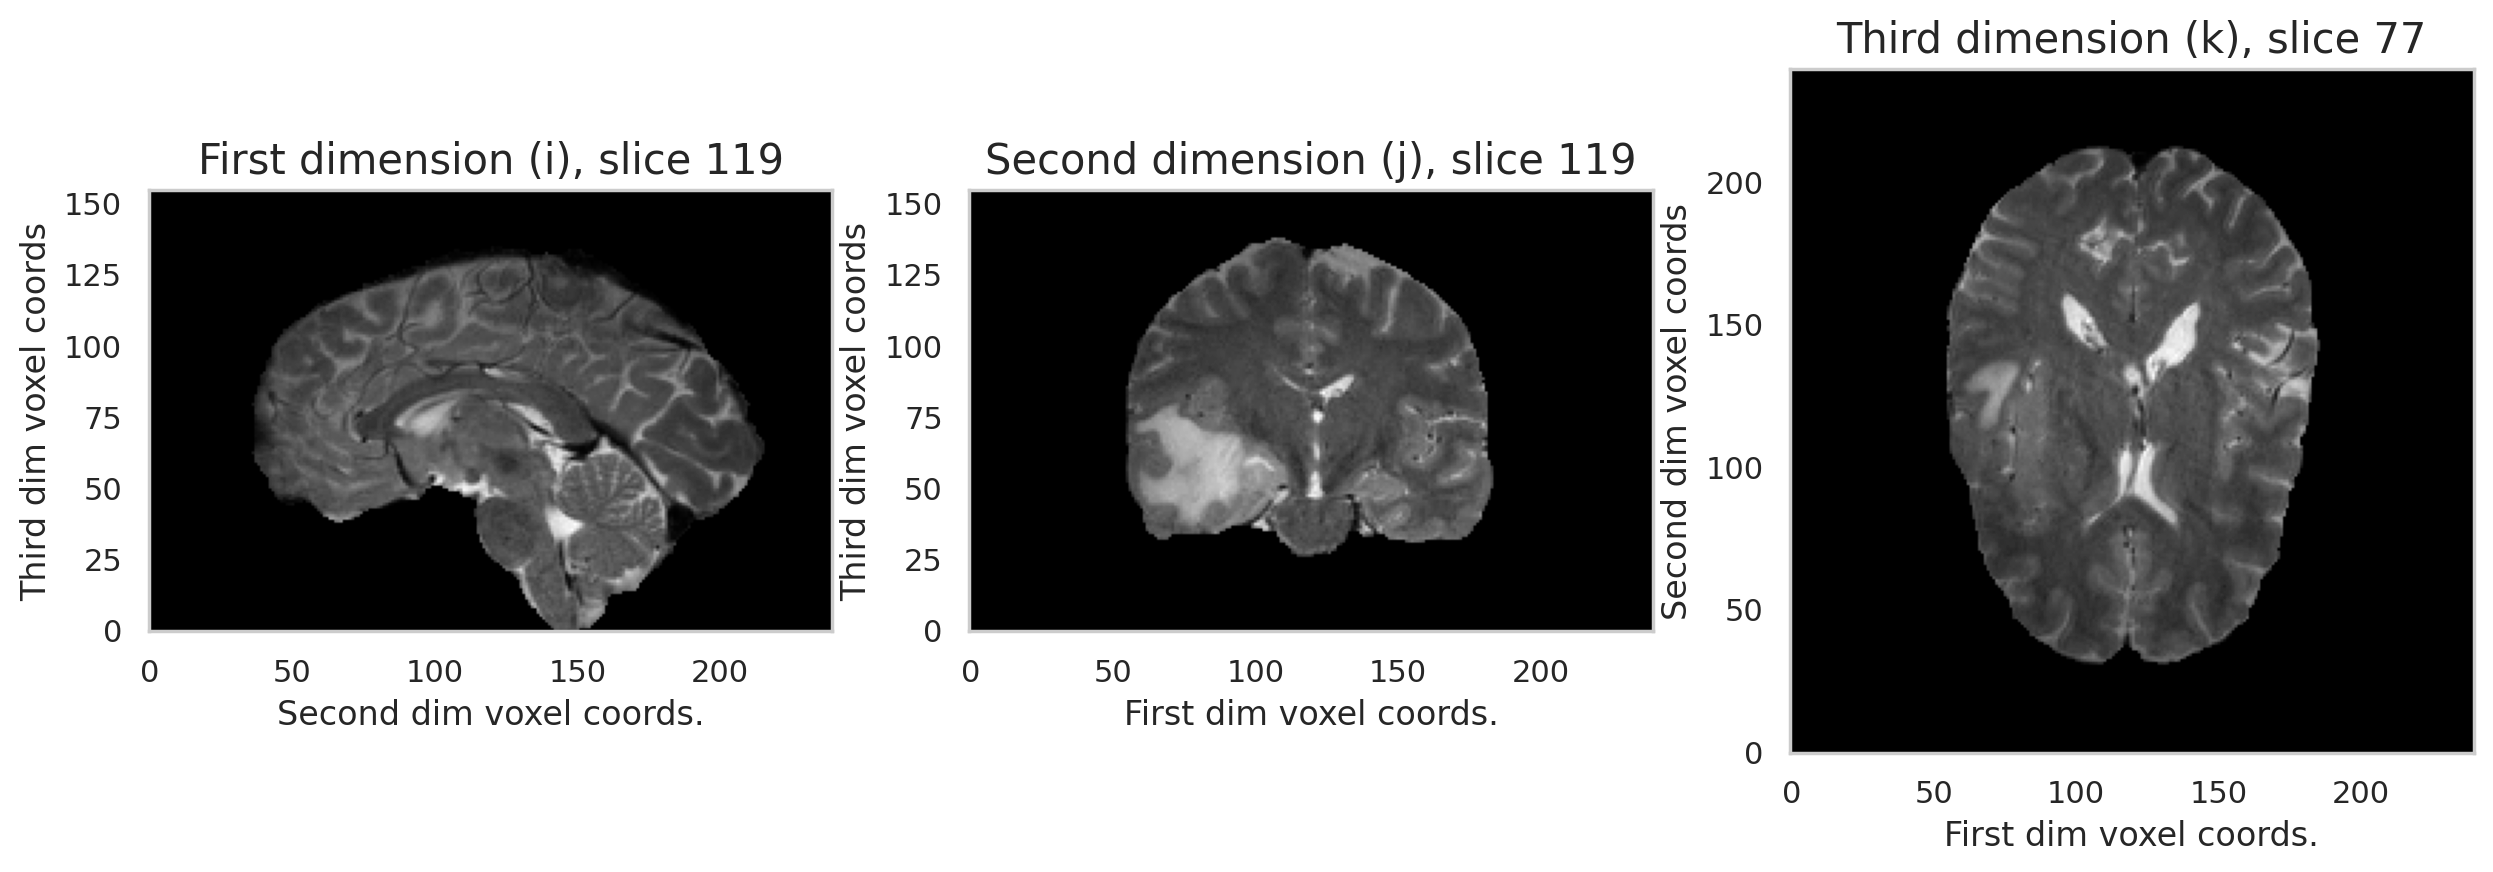

In [ ]:
n_i, n_j, n_k = image.shape
i = (n_i - 1) // 2
j = (n_j - 1) // 2
k = (n_k - 1) // 2
print(i, j, k)

slice_0 = image[i, :, :]
slice_1 = image[:, j, :]
slice_2 = image[:, :, k]
show_slices([slice_0, slice_1, slice_2])

# Excersice 2: Preprocessing MRI with TorchIO: Spatial Transformations

[TorchIO](https://torchio.readthedocs.io) is an open-source Python library for efficient loading, preprocessing, augmentation and patch-based sampling of 3D medical images in deep learning, following the design of PyTorch.

Load the dataset from TorchIO and display them.


10862592it [00:00, 31010594.19it/s]         


548864it [00:00, 1605336.61it/s]          


8192it [00:00, 42742.96it/s]           


16384it [00:00, 64980.68it/s]           


2203648it [00:00, 4243877.09it/s]          


23838720it [00:00, 50823984.89it/s]         


10174464it [00:00, 19031468.66it/s]         


Sample subject: FPG(Keys: ('t1', 'seg', 't2', 'fmri', 'dmri'); images: 5)
ScalarImage(shape: (1, 256, 256, 176); spacing: (1.00, 1.00, 1.00); orientation: PIR+; path: "/root/.cache/torchio/fpg/t1.nii.gz")
ScalarImage(shape: (1, 320, 320, 26); spacing: (0.75, 0.75, 5.50); orientation: LAS+; path: "/root/.cache/torchio/fpg/t2.nii.gz")


<ipython-input-4-3f21a07129b9>:102: UserWarning: Image orientation should be RAS+, not PIR+
  warnings.warn(f'Image orientation should be RAS+, not {orientation}+')


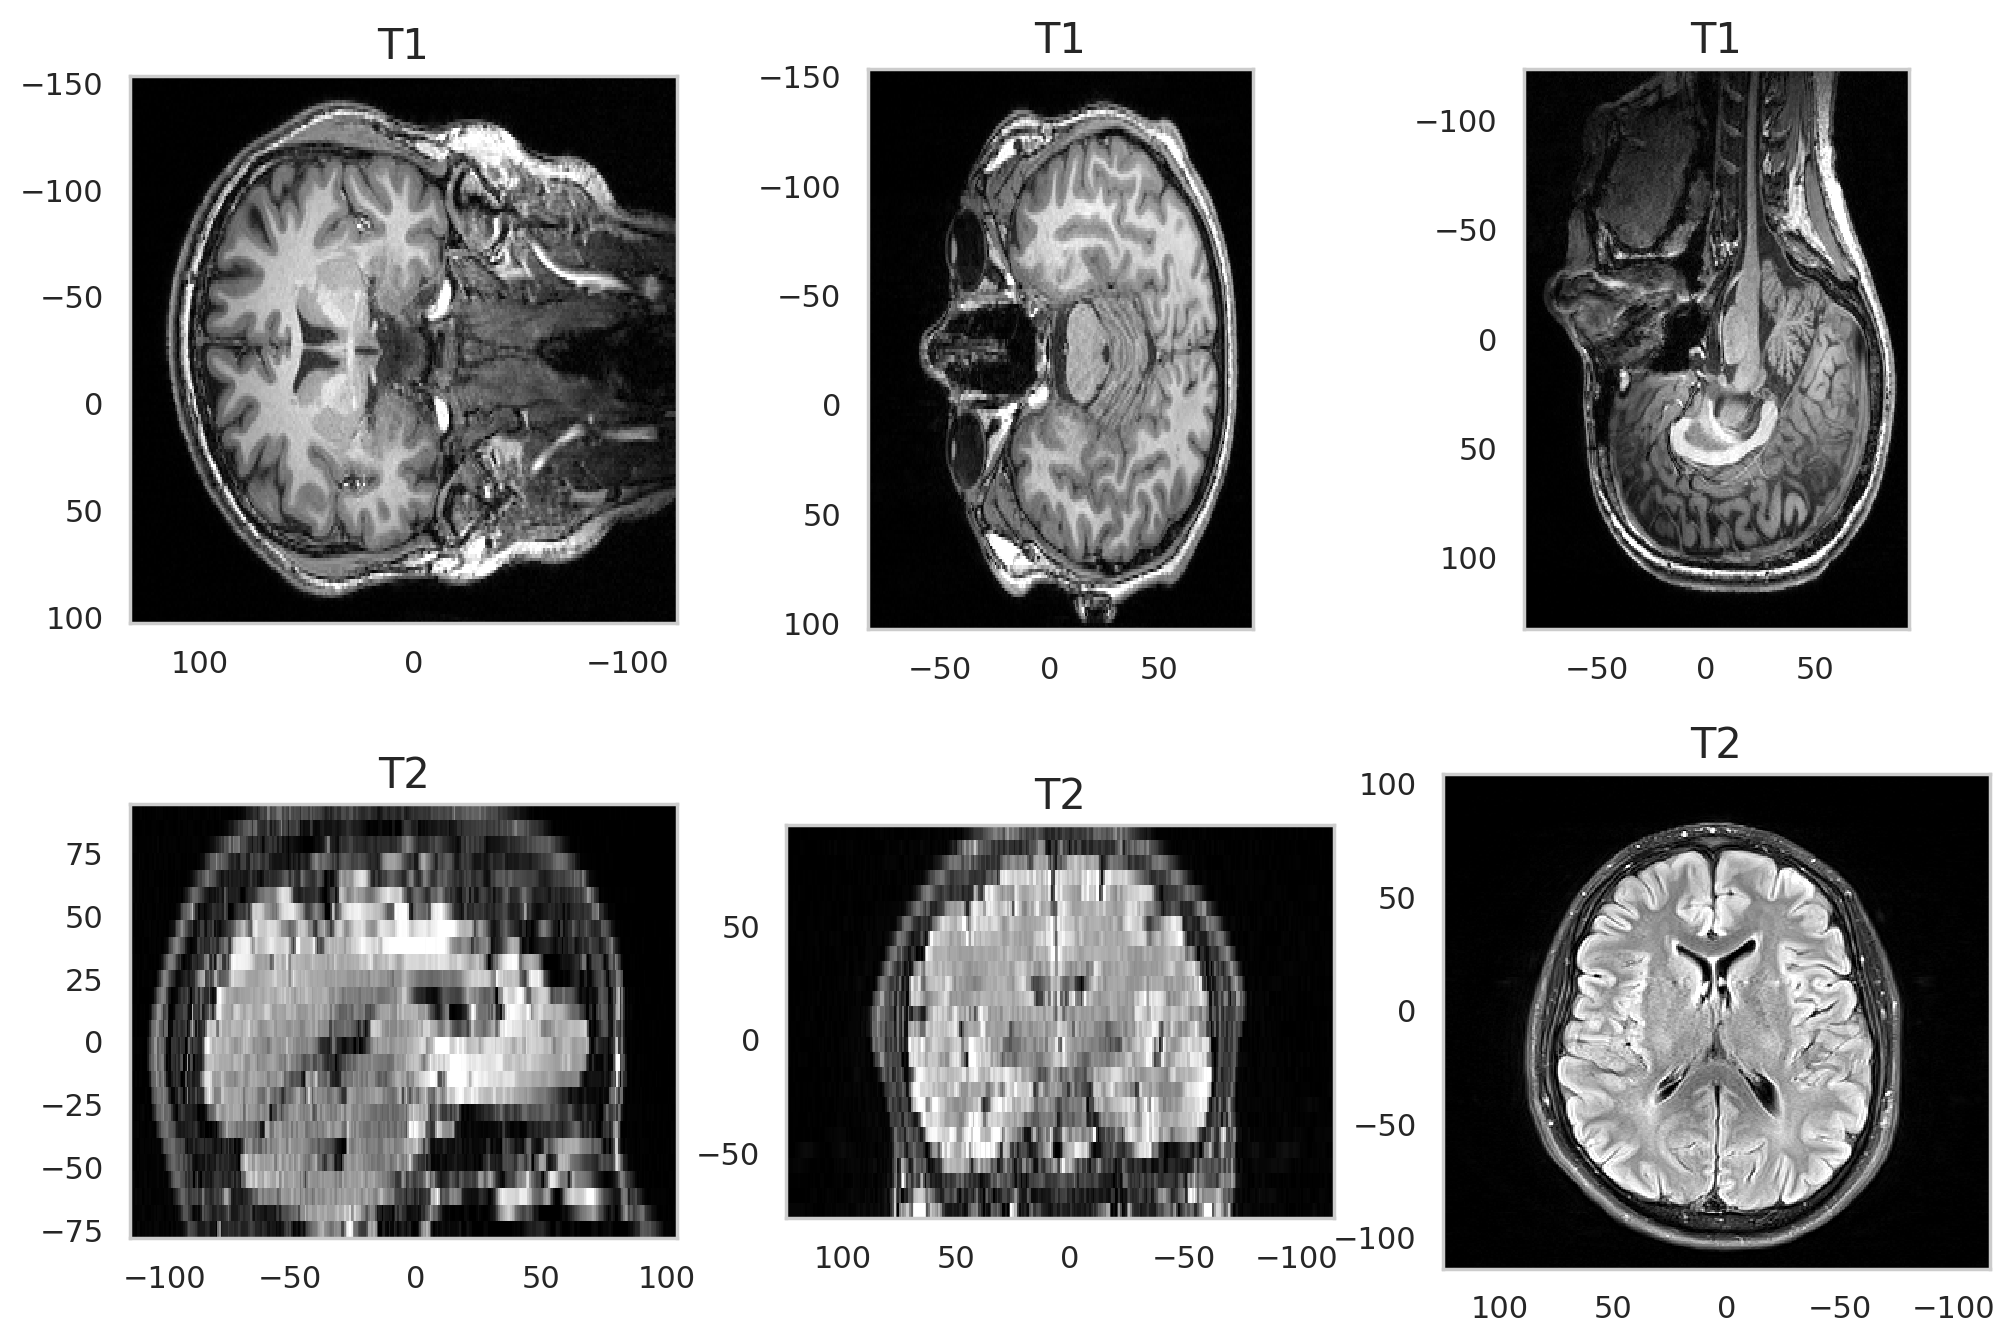

In [ ]:
fpg = tio.datasets.FPG(load_all = True)
print('Sample subject:', fpg)
print(fpg.t1)
print(fpg.t2)

show_fpg(fpg)

## Your tasks:
1. Fix the orientation of the images. Use the canonical transformation to ensure consistent orientation across our dataset.
2. Fix the spacing by putting our dataset in the same standard space (the MNI space)
3. Crop or pad the images to the `target_shape = 150, 190, 170`
4. If the dataset is too heavy you can always downsample. You can make your code to run faster but the resolution of your images is decreased. Try downsapling by 5 and then by 2. Comment on the difference you see.

T1w old orientation: ('P', 'I', 'R')
T1w new orientation: ('R', 'A', 'S')
T2w old orientation: ('L', 'A', 'S')
T2w new orientation: ('R', 'A', 'S')


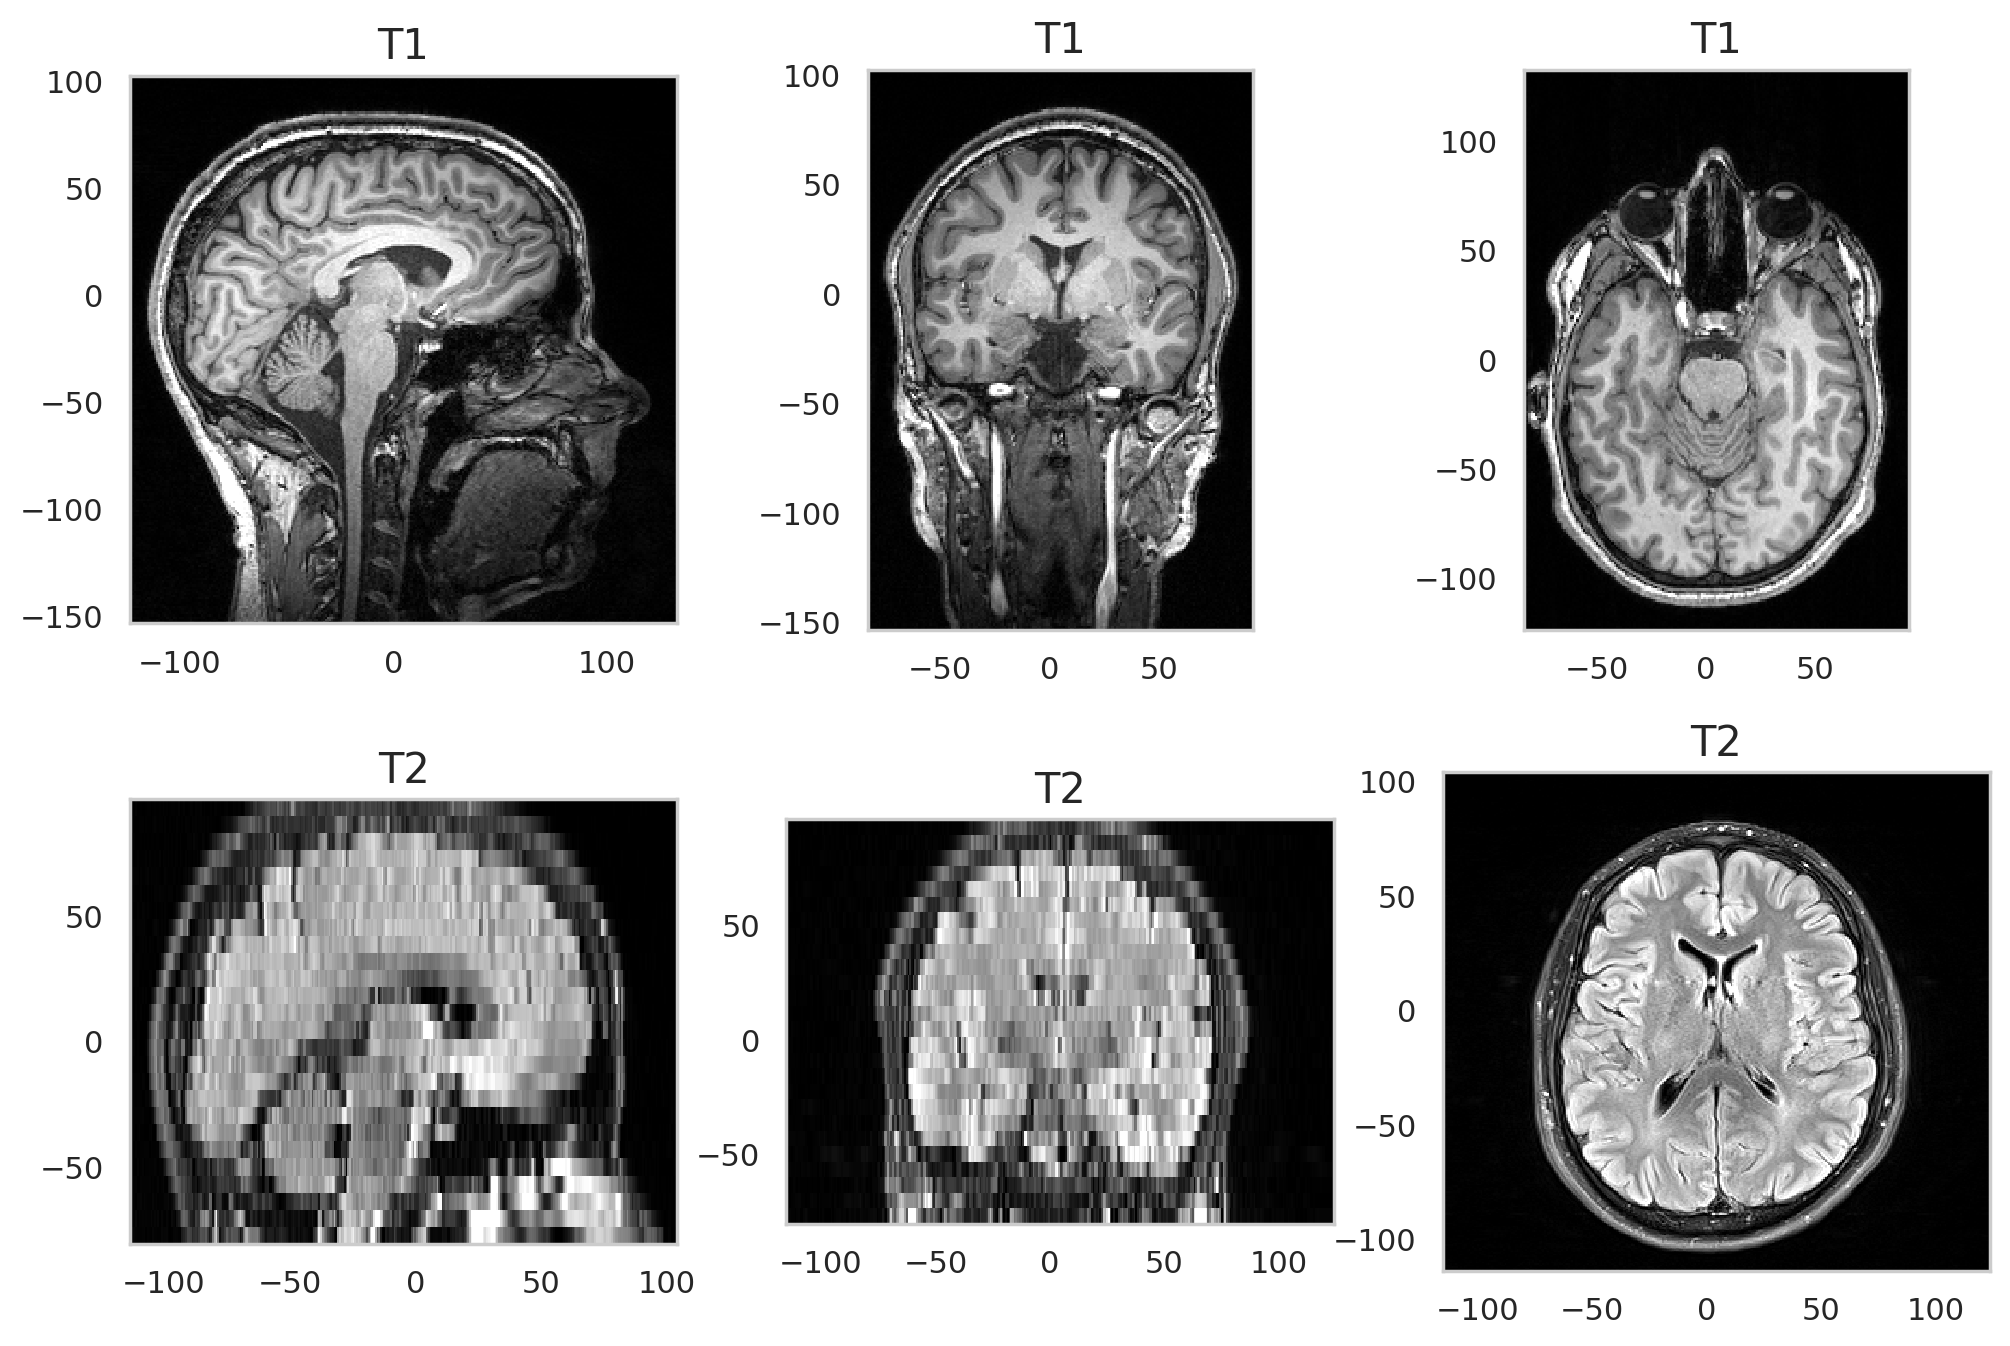

In [ ]:
RAS_orientation = tio.ToCanonical()
fpg_RAS = RAS_orientation(fpg)
print('T1w old orientation:', fpg.t1.orientation)
print('T1w new orientation:', fpg_RAS.t1.orientation)
print('T2w old orientation:', fpg.t2.orientation)
print('T2w new orientation:', fpg_RAS.t2.orientation)
show_fpg(fpg_RAS)

# Excersice 3: Preprocessing MRI with TorchIO: Data Augmentation

Data augmentation helps increase the number of data images we can feed the model and helps the model generalize.

## Your tasks:
1. Add random anisotropy to our dataset and visualize it
2. Add random affine to our dataset and visualize it
3. Add random flip along the anterior-posterior axis with probability = 0.5 to our dataset and visualize it
4. Add random elastic deformation with `max_displacement = 10, 20, 15` to our dataset and visualize it

In [ ]:
#Resampling Images based on tutorial notebook

resample_factor = 3
original_spacing = 1
target_spacing = resample_factor / original_spacing
downsample = tio.Resample(target_spacing)
fpg_RAS = downsample(fpg_RAS)

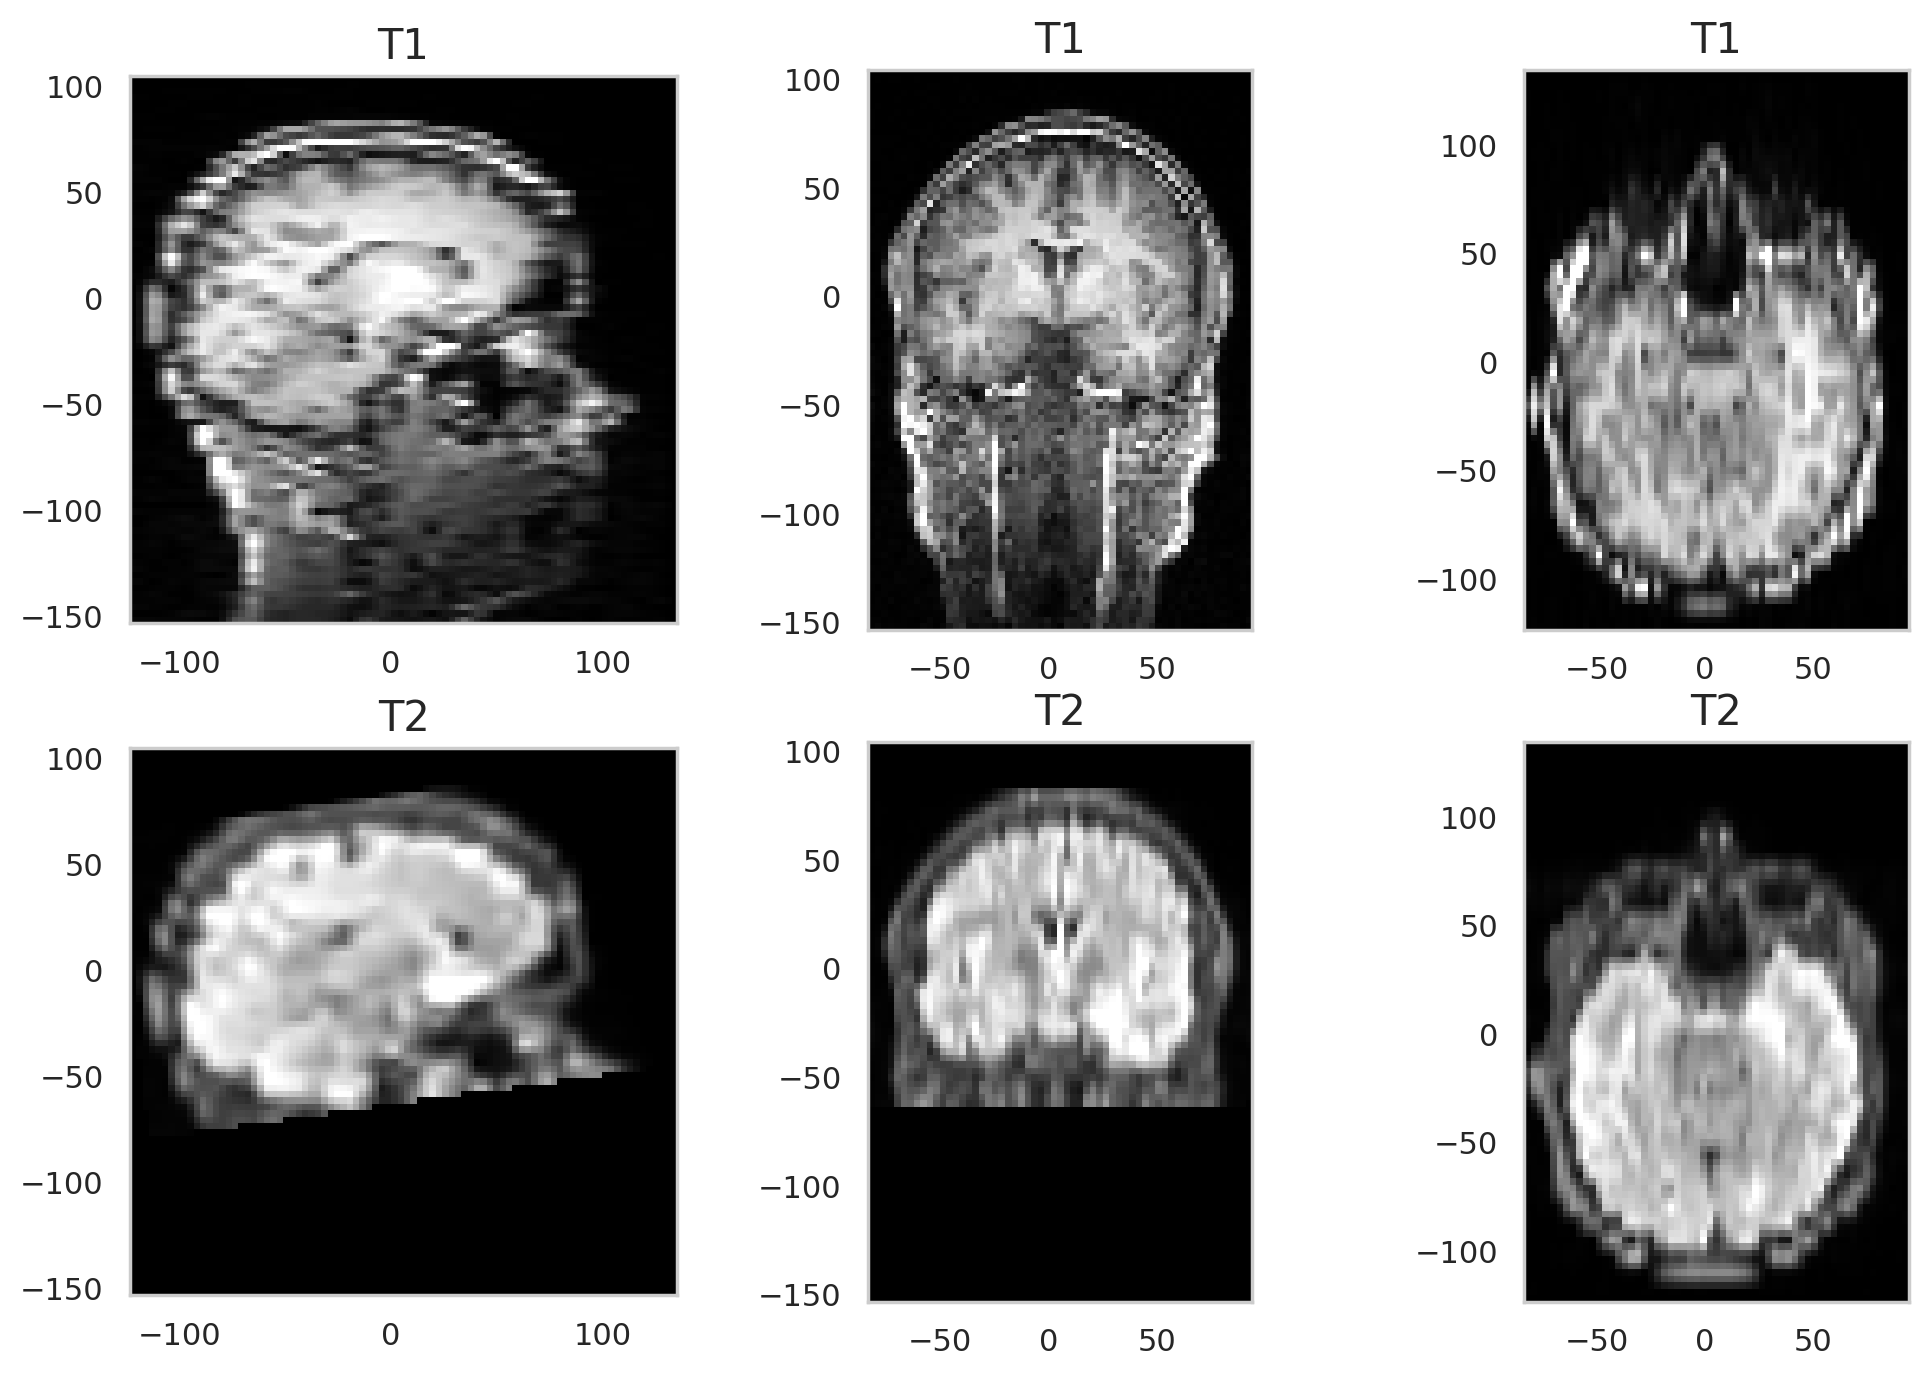

In [ ]:
#Random Anisotropy

random_anisotropy = tio.RandomAnisotropy()
anisotropy_transformed = random_anisotropy(fpg_RAS)

show_fpg(anisotropy_transformed)

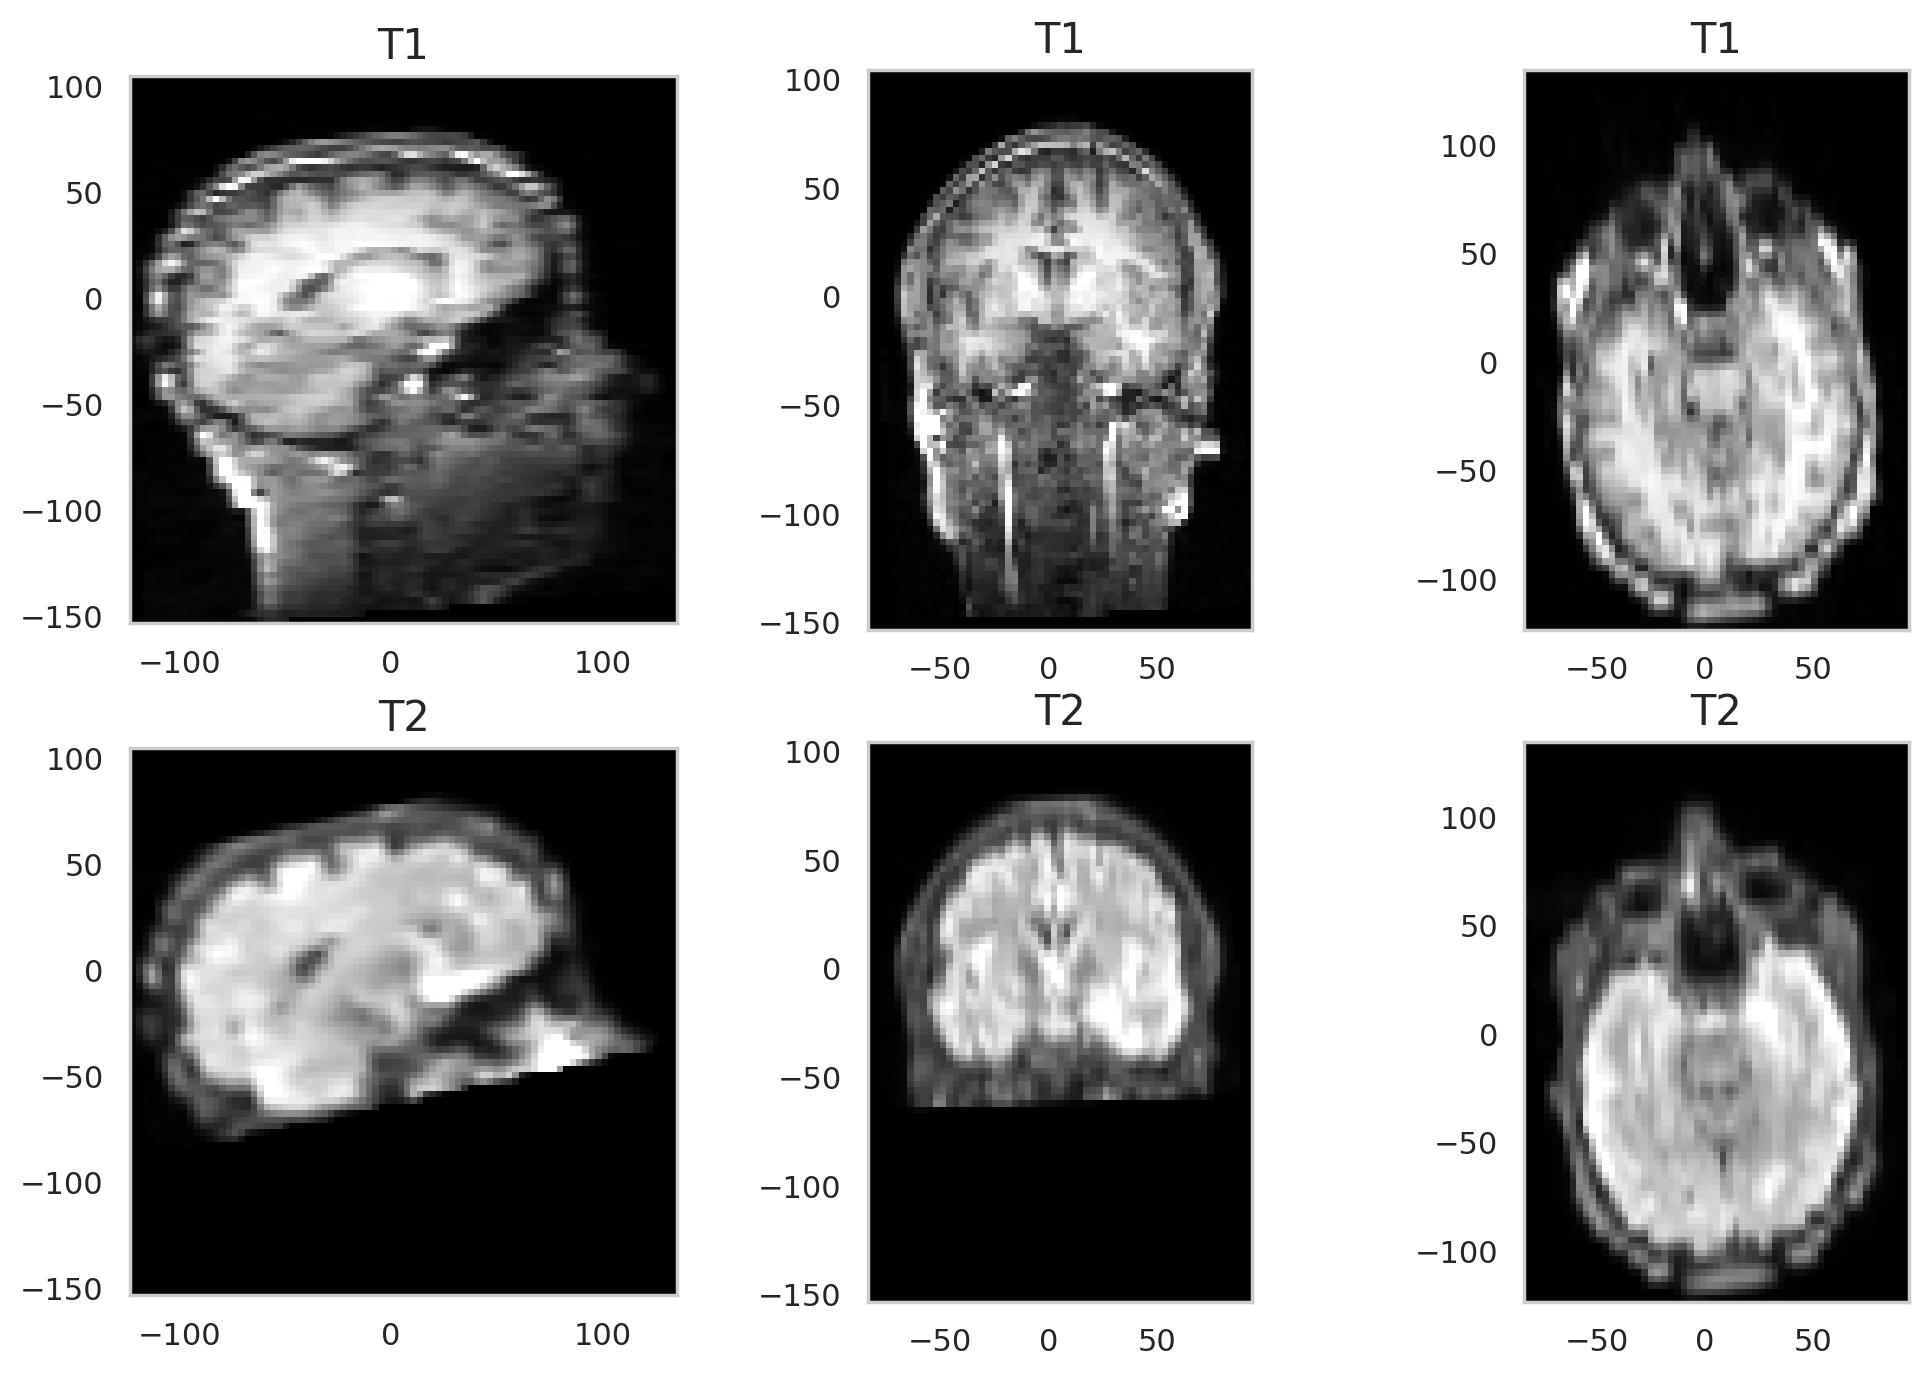

In [ ]:
#Random Affine

random_affine = tio.RandomAffine()
affine_transformed = random_affine(anisotropy_transformed)

show_fpg(affine_transformed)

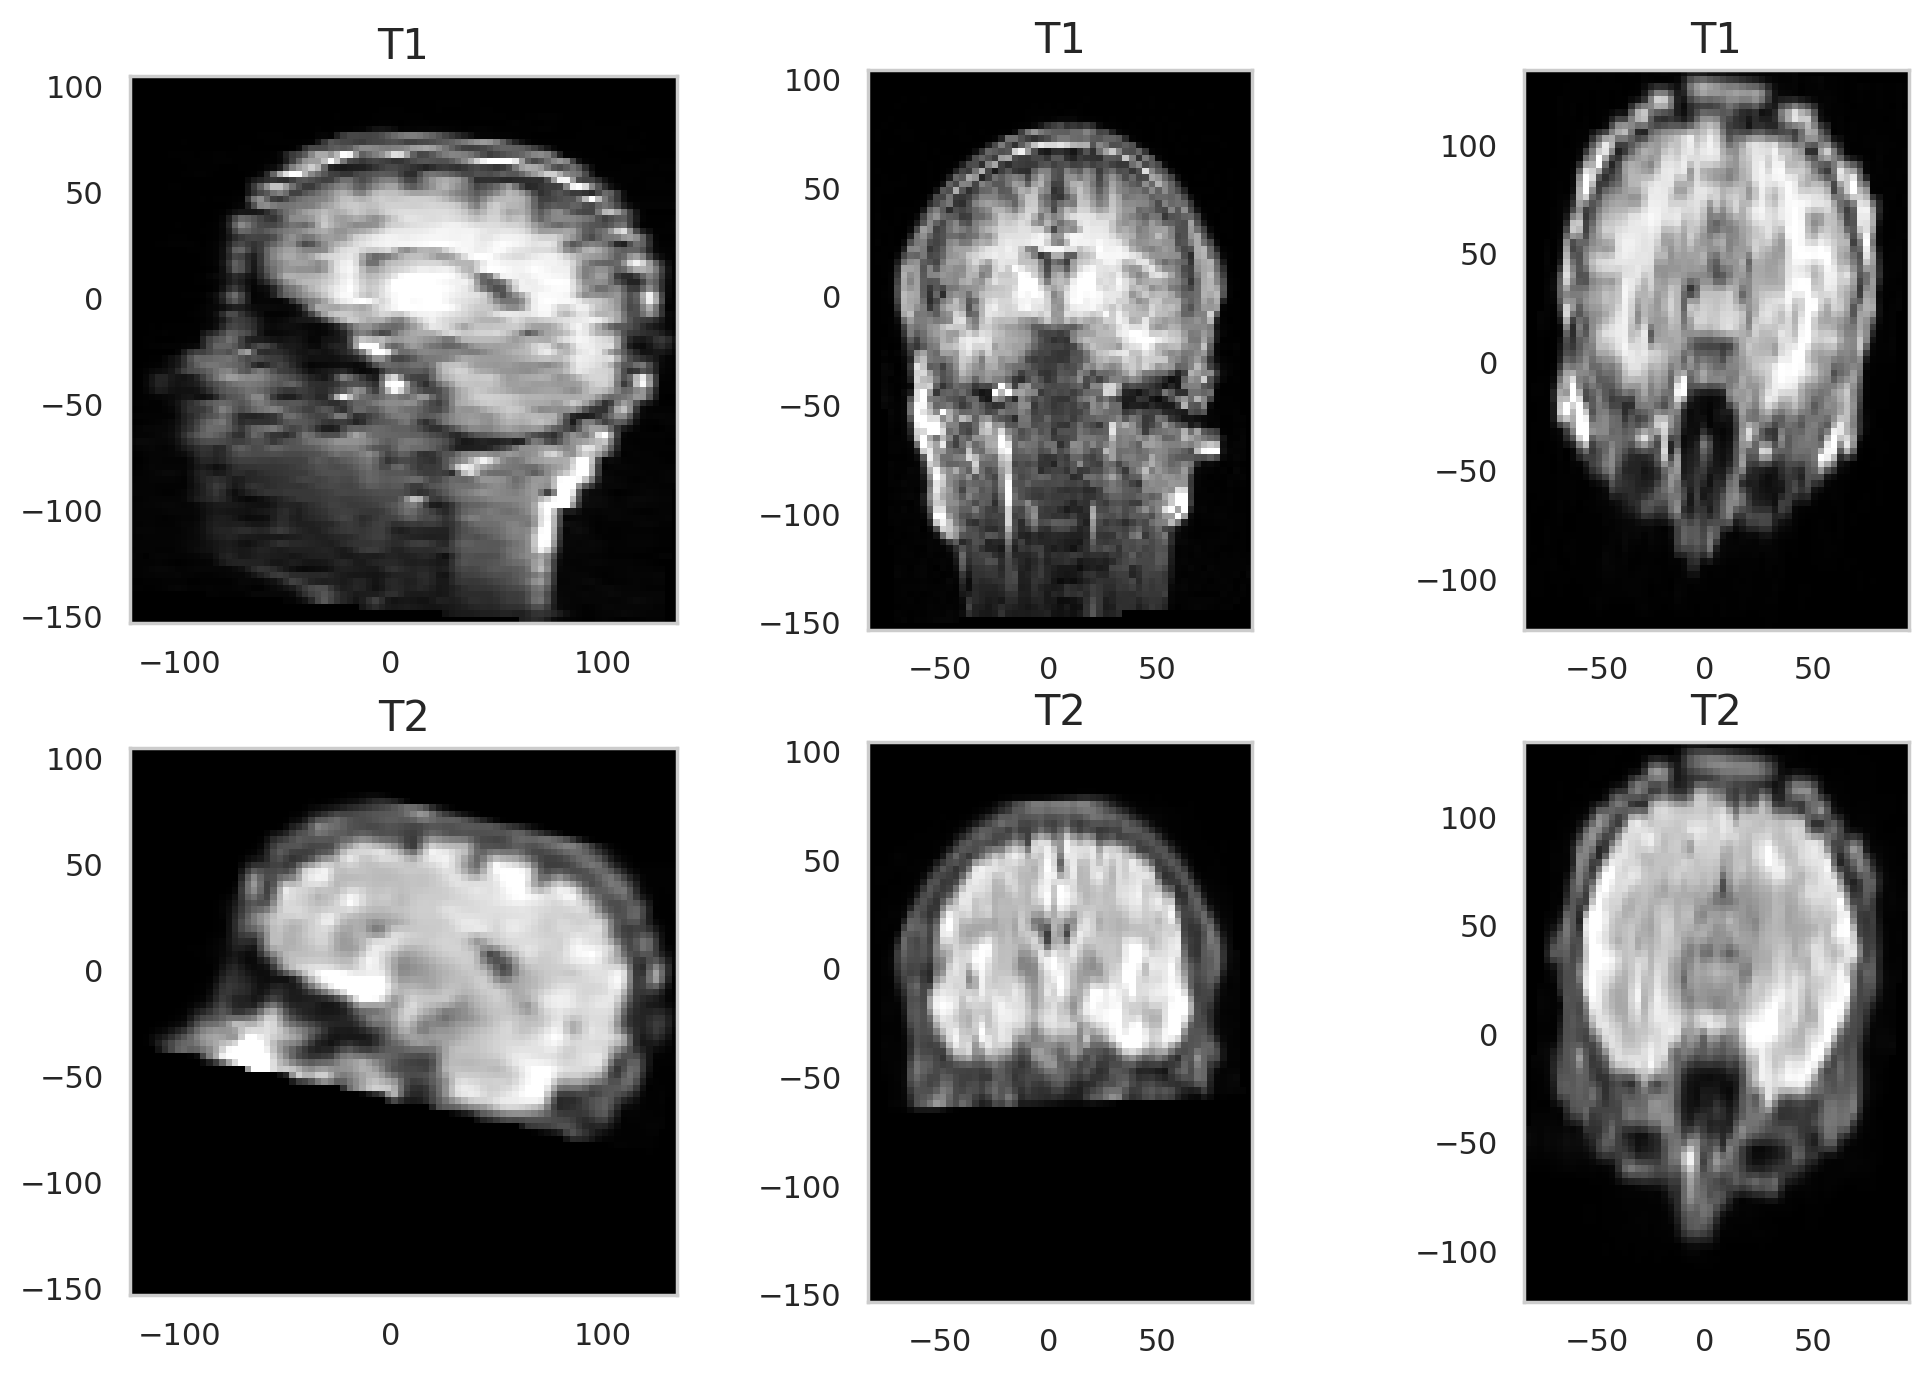

In [ ]:
#Random Flip

random_flip = tio.RandomFlip(axes='AP', p=0.5)
flip_transformed = random_flip(affine_transformed)

show_fpg(flip_transformed)

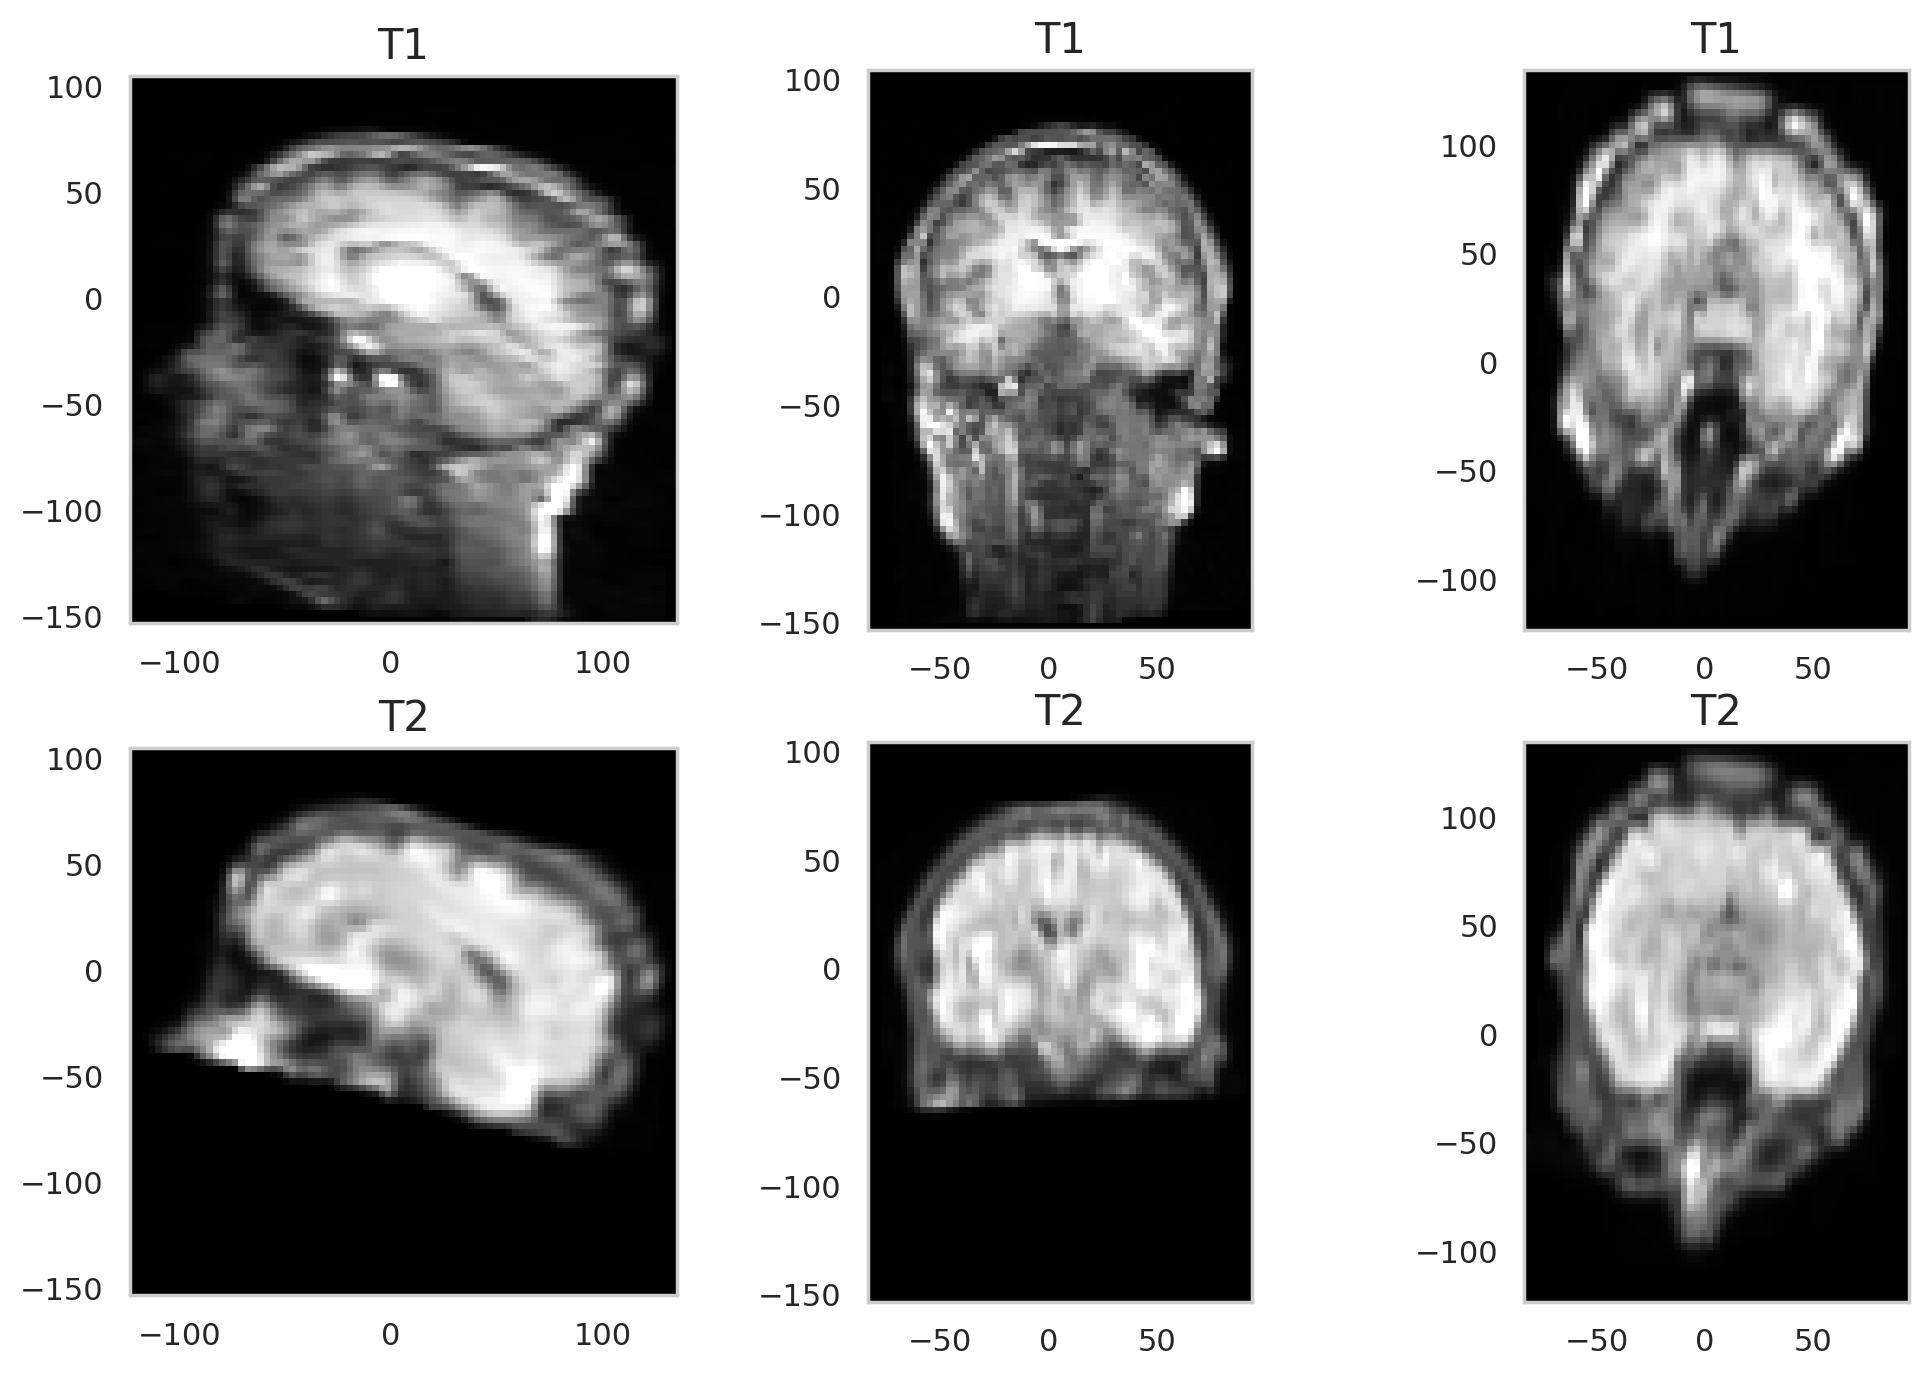

In [ ]:
random_elastic = tio.RandomElasticDeformation(max_displacement=(10, 20, 15))
elastic_transformed = random_elastic(flip_transformed)

show_fpg(elastic_transformed)

# Excersice 4: Preprocessing MRI with TorchIO: Intensity Transforms

## Your tasks:
1. Rescale the intensity of our dataset to the range (0,1) and ignore all pixel values outside the 1% and 99% percentiles. Visualize it
2. Add random blur to our dataset and visualize it
3. Add random noise to our dataset and visualize it
4. Add k-space transformations to our dataset including random spike, random ghosting, and random motion, and visualize them

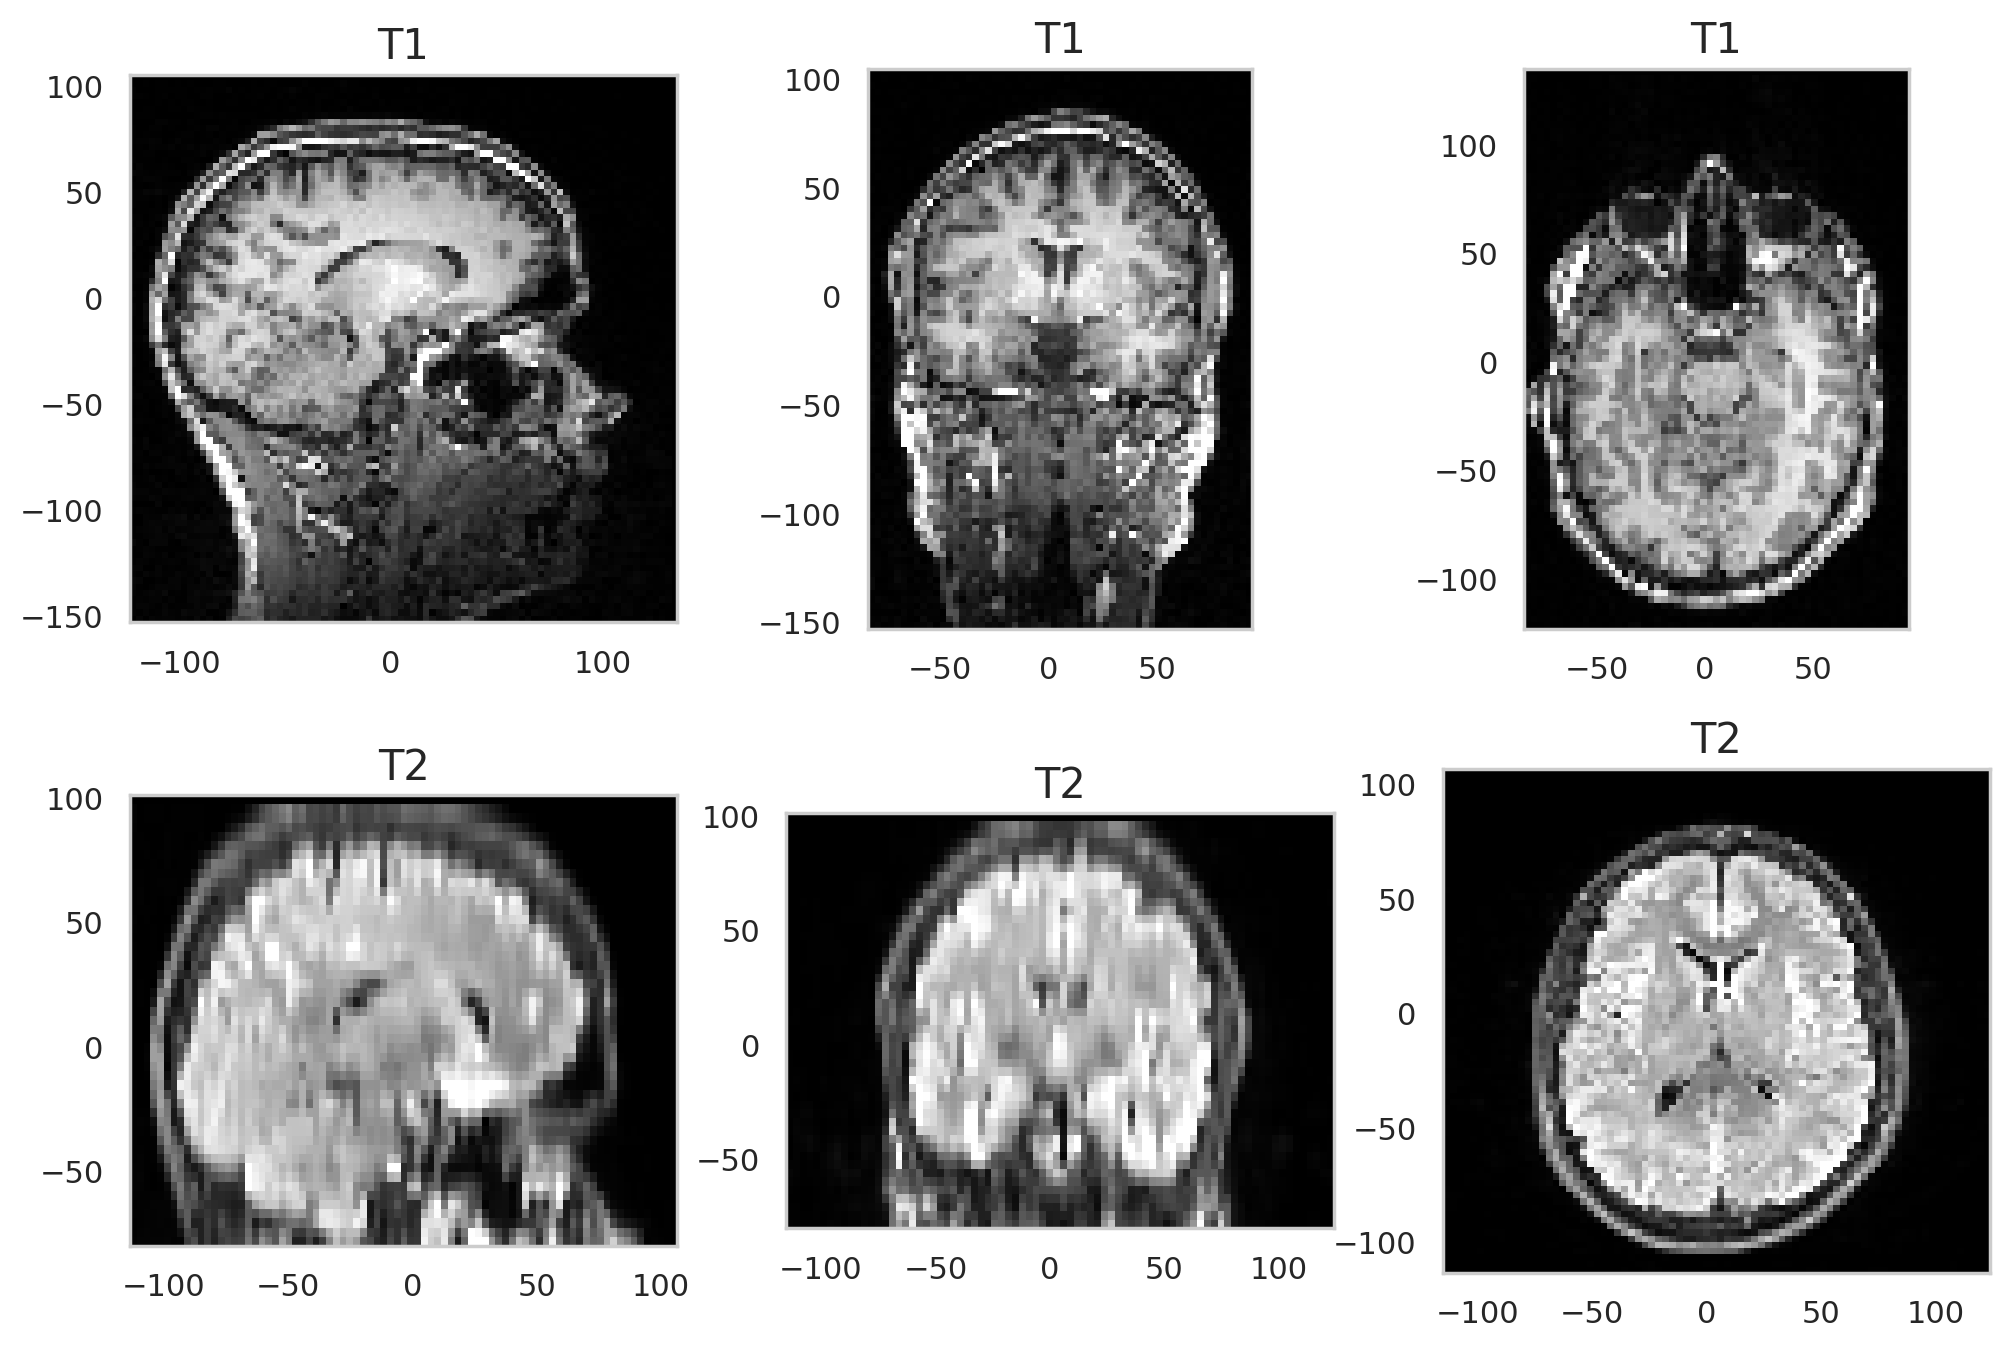

In [ ]:
# Rescaling Intensity
rescale_intensity = tio.RescaleIntensity((0, 1), percentiles=(1, 99))
fpg_Rescaled = rescale_intensity(fpg_RAS)
show_fpg(fpg_Rescaled)

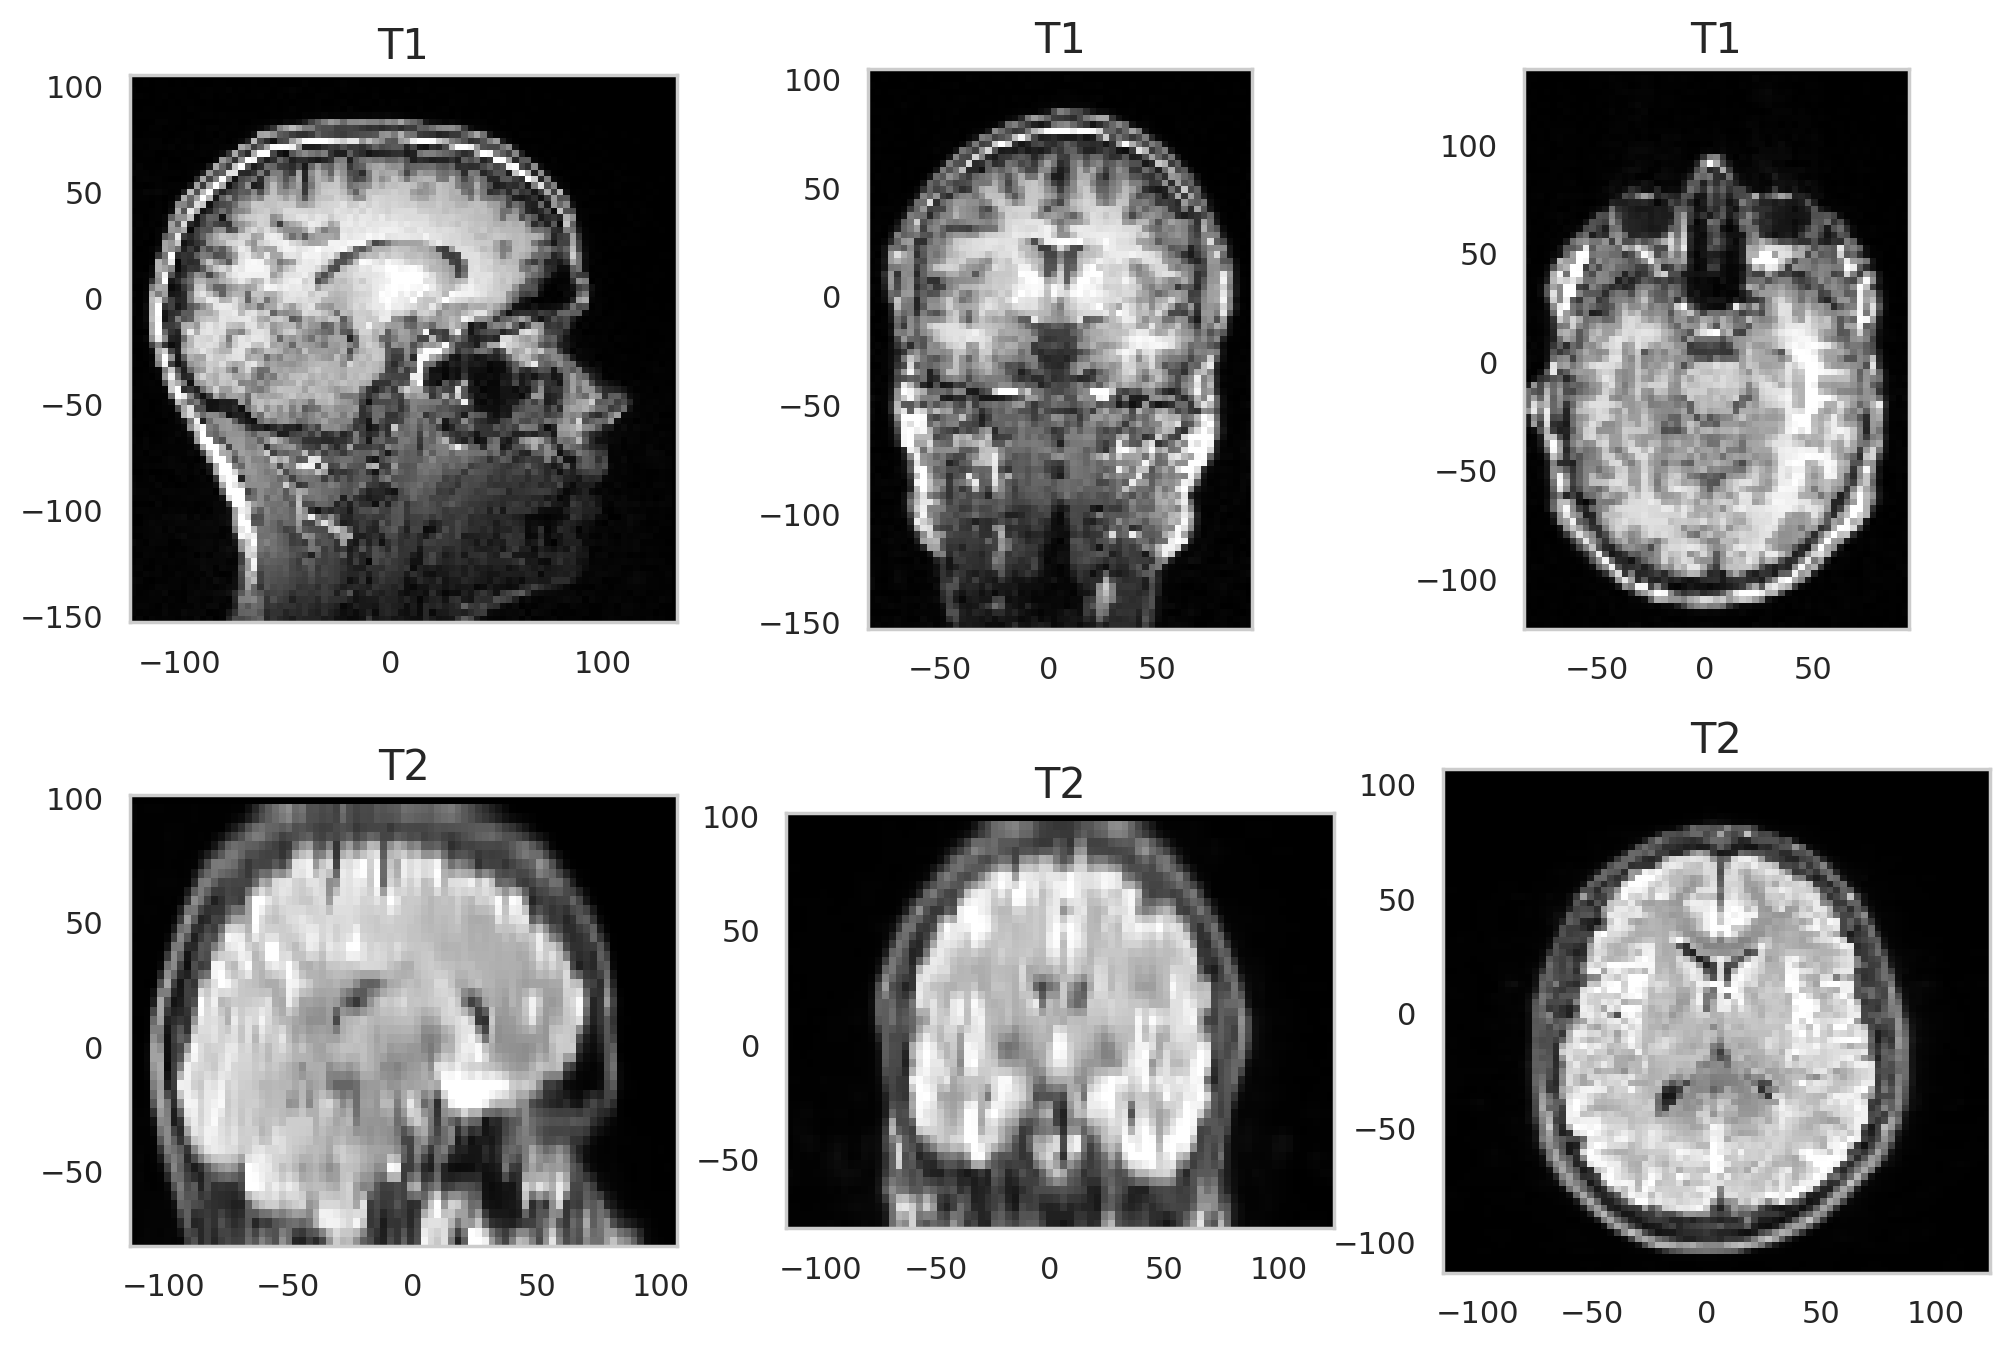

In [ ]:
# Adding random blur
rand_blur = tio.RandomBlur()
fpg_blur = rand_blur(fpg_Rescaled)

show_fpg(fpg_blur)

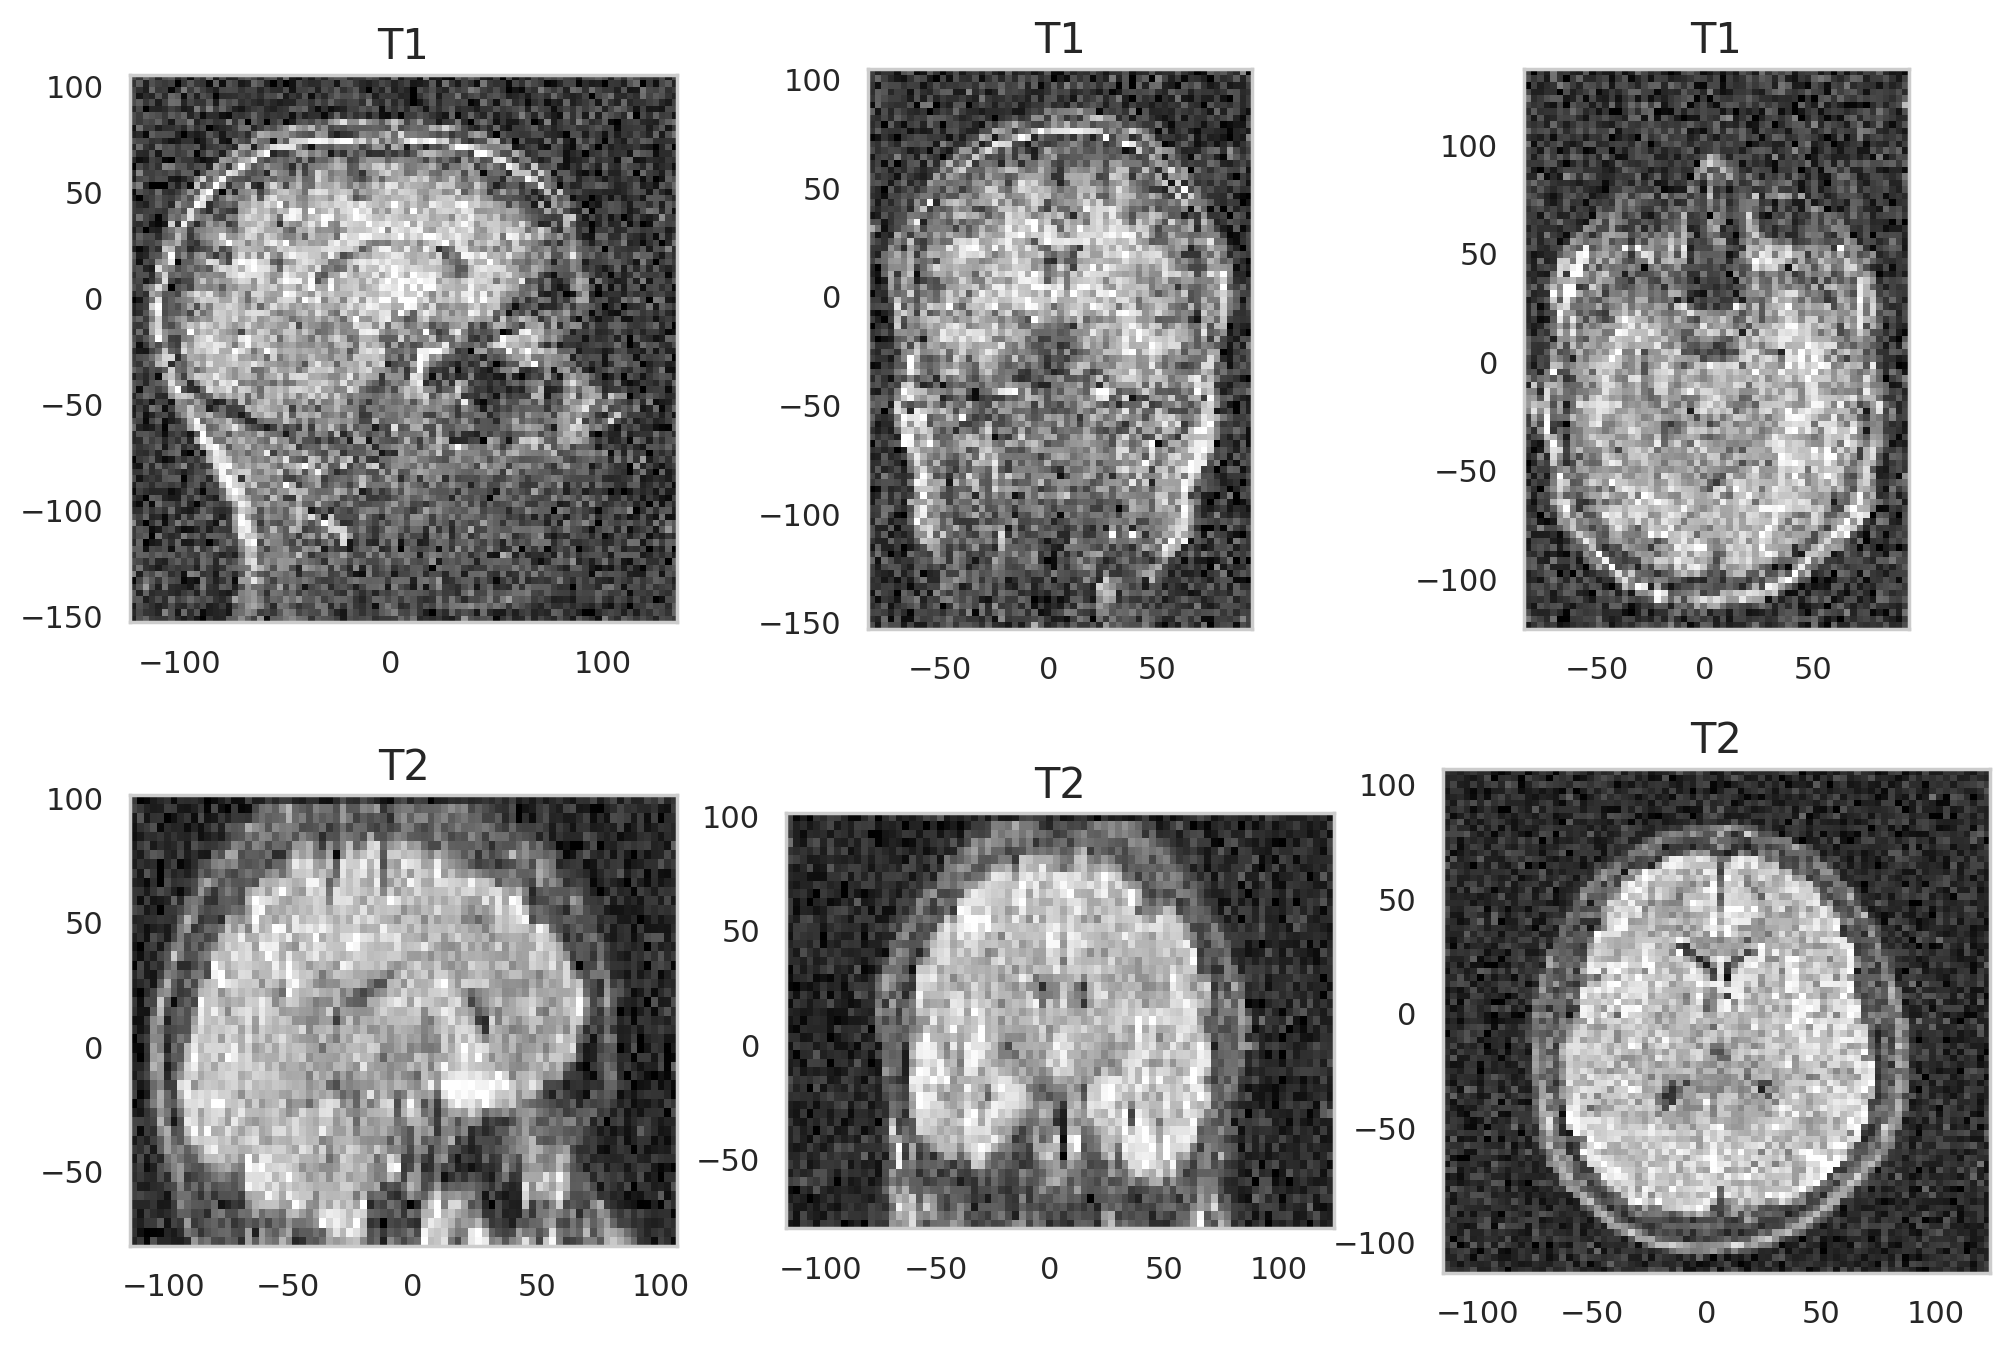

In [ ]:
# Adding random noise
rand_noise = tio.RandomNoise()
fpg_noise = rand_noise(fpg_Rescaled)

show_fpg(fpg_noise)

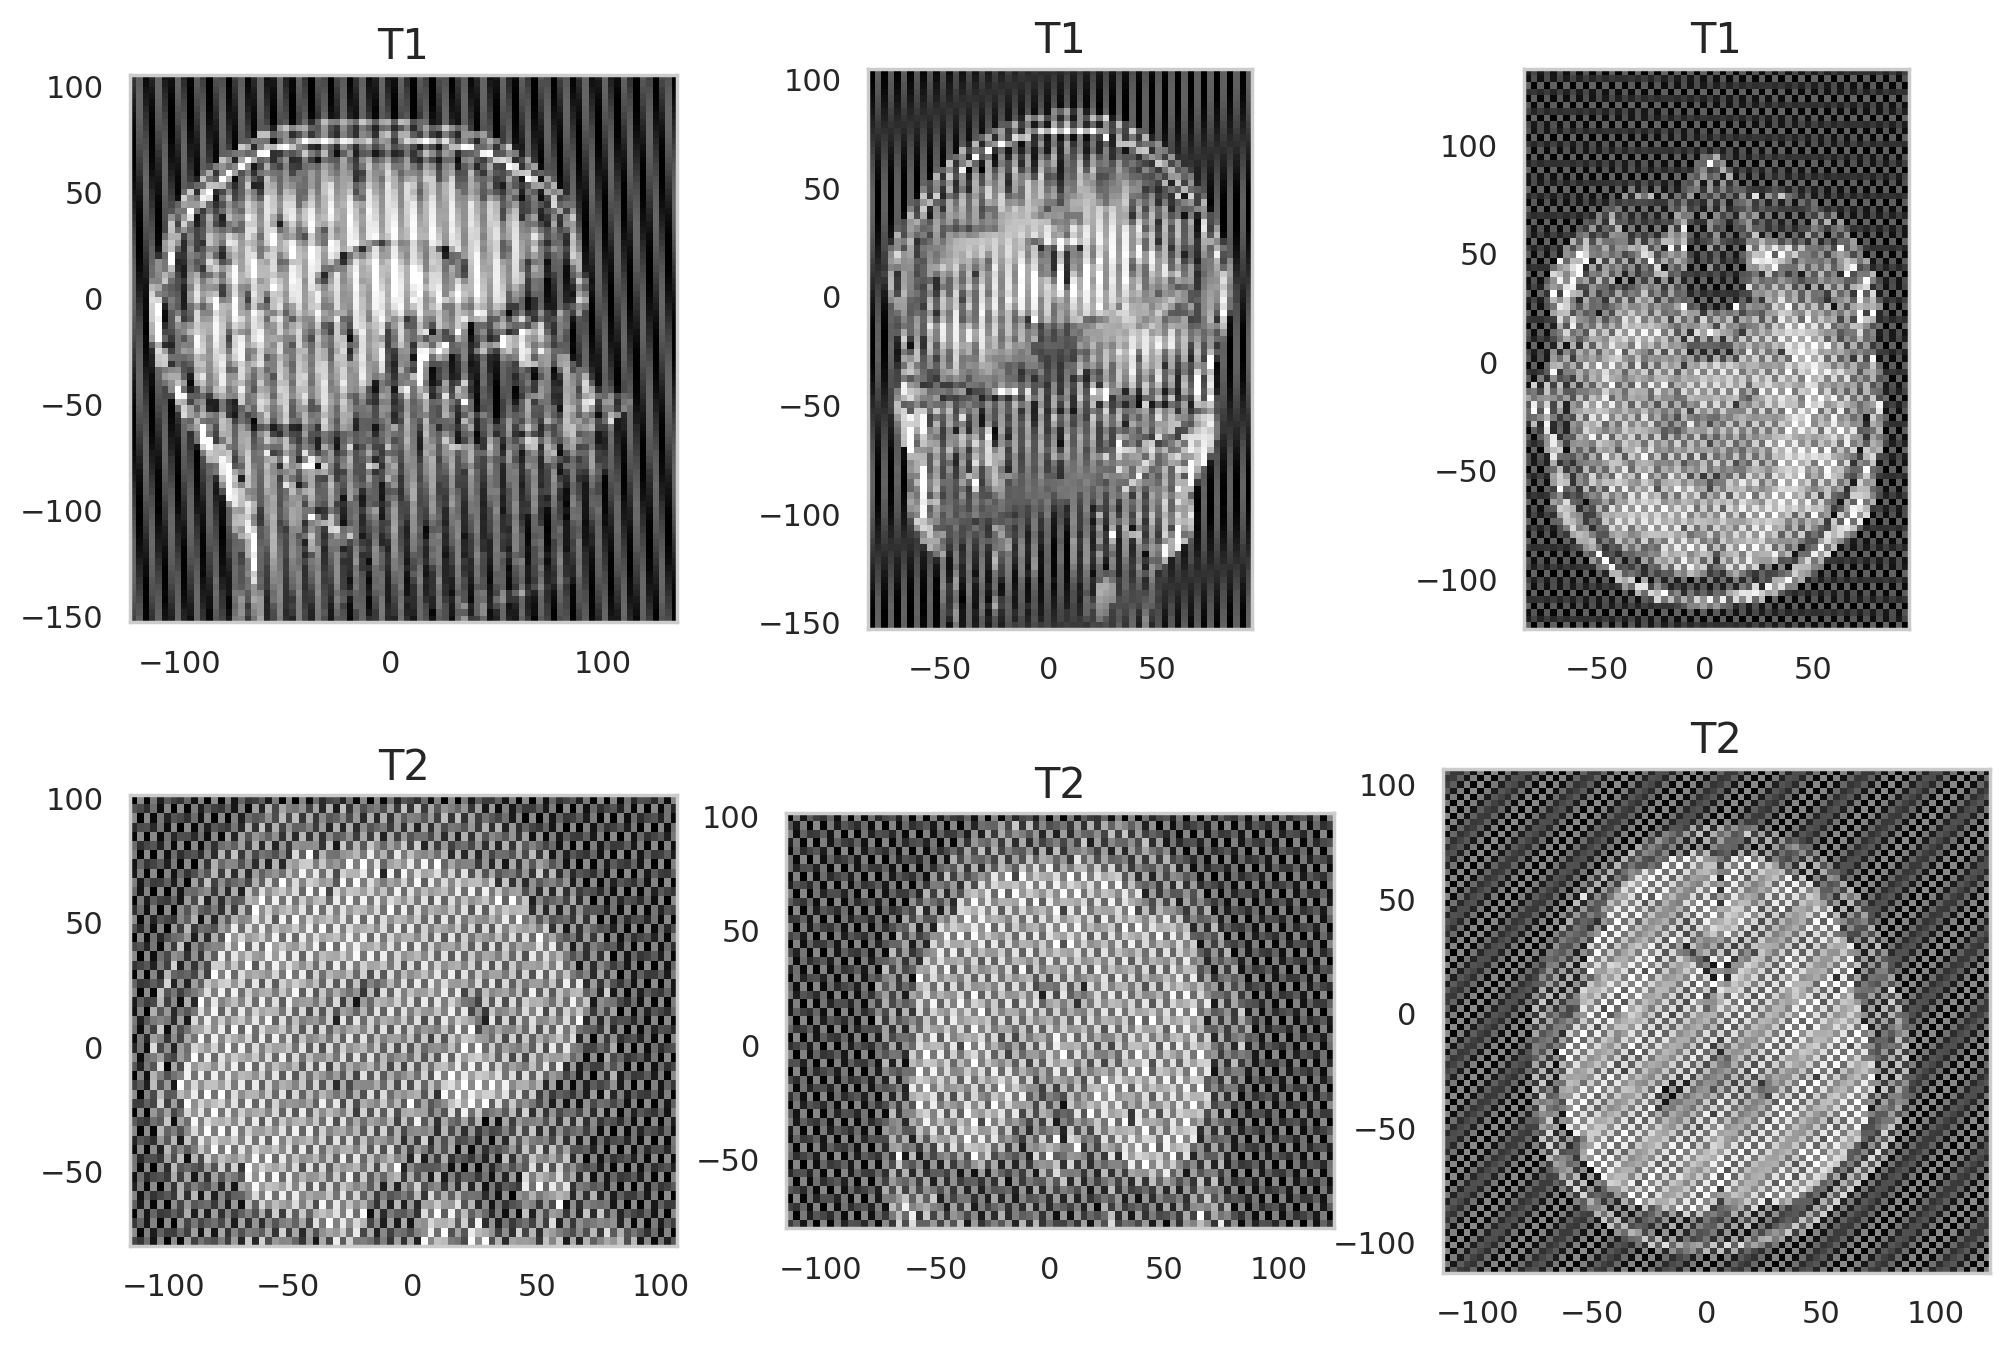

In [ ]:
#Adding K-SpaceInformation

spike, ghost, motion  = tio.RandomSpike(), tio.RandomGhosting(), tio.RandomMotion()
fpg_spike = spike(fpg_Rescaled)
fpg_ghost = ghost(fpg_Rescaled)
fpg_motion = ghost(fpg_Rescaled)
show_fpg(fpg_spike)

In [ ]:
show_fpg(fpg_ghost)

In [ ]:
show_fpg(fpg_motion)

# Exercise 5 (bonus): Apply a chain of transformations

## Your task:
Use Compose to chain some of the above transformations of your choice (from exercises 2-4) and apply them on our dataset
- Be mindful of RAM limits
- Use `OneOf` and the `p` kwarg wisely

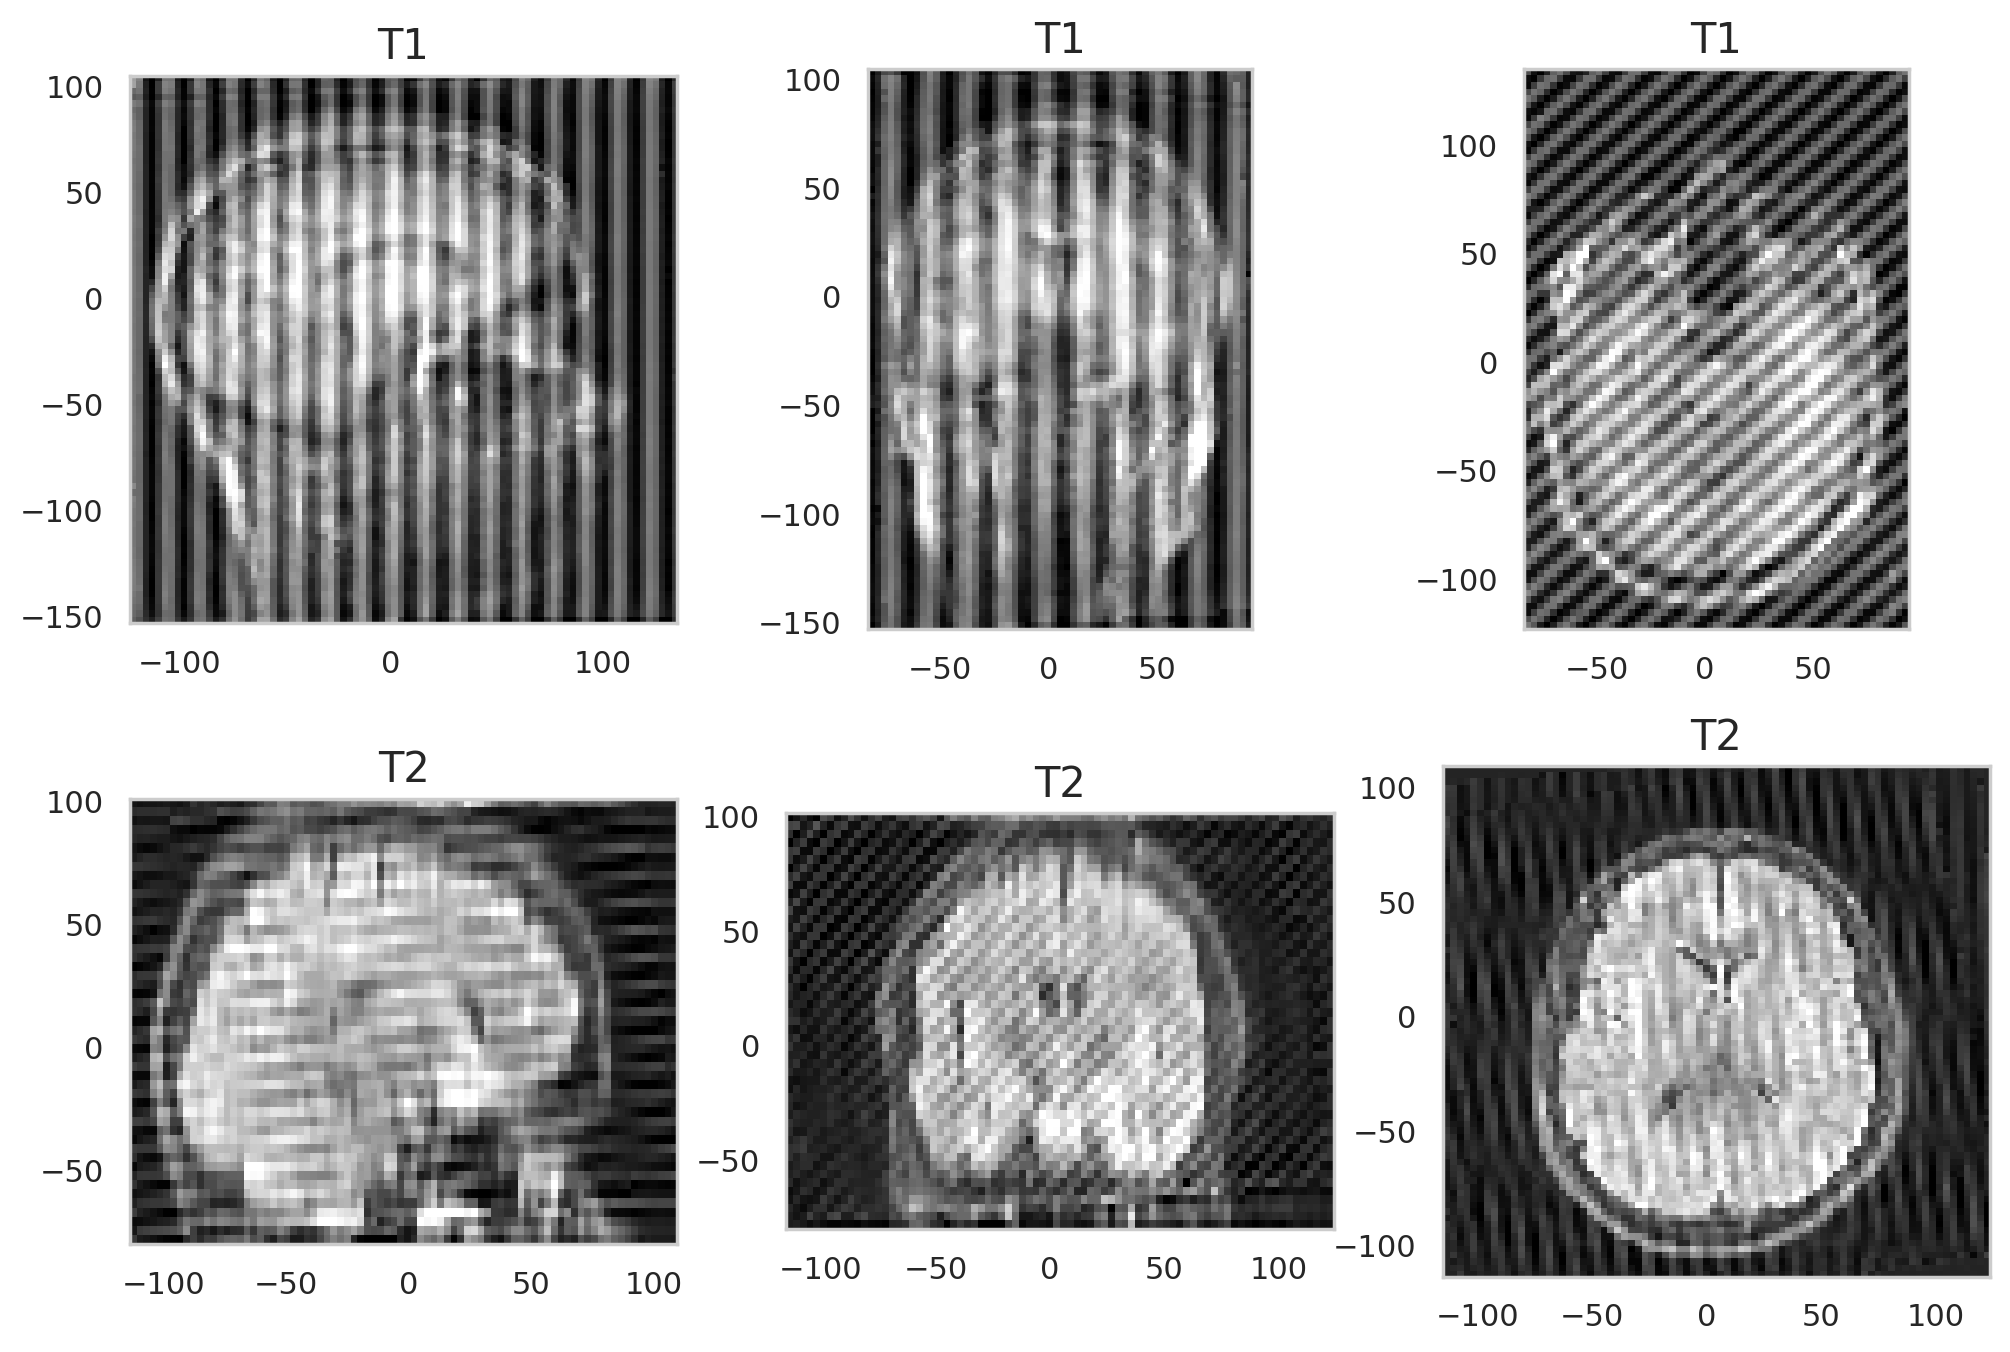

In [ ]:
#Just like pytorch's transform.compose

chain_tranform = tio.Compose([tio.Resample(target_spacing),
                              tio.RandomAnisotropy(p=0.5),
                              tio.RandomSpike(),
                              tio.RandomGhosting(),
                              tio.RandomMotion()])

fpg_chain_transformed = chain_tranform(fpg_RAS)
show_fpg(fpg_chain_transformed)

# Congratulations! You know how to load, display and pre-process MRI images

#Assignment Solution

[solution](https://colab.research.google.com/drive/1NFj_xhQmqEM5aS36Lc3CHv9o1_zBtxOG?usp=sharing)

Only look at the solutions when you have attempted the exercises

# References:

[BraTS2020 Dataset](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation) from Kaggle.


